## Применение методов глубокого обучения для классификации текстов на основе семантического анализа.

dataset: <a href='https://www.aicrowd.com/challenges/ai-blitz-xii/problems/programming-language-classification'>link</a>

In [1]:
import pandas as pd
import numpy as np
import os
import re
import copy
import random
import time

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, normalize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import classification_report, accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors

import networkx as nx
from node2vec import Node2Vec
from gensim.models import Word2Vec

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from torch_geometric.data import Data
from torch_geometric.nn import GATConv, SAGEConv, JumpingKnowledge

from transformers import AutoTokenizer, AutoModel

# import optuna
# from optuna.samplers import TPESampler

from tqdm import tqdm, trange
from tqdm.notebook import tqdm as tqdmn

In [ ]:
!pip install numpy==1.26.4 scipy==1.13.1 gensim==4.3.3 node2vec==0.5.0 torch_geometric==2.6.1

In [2]:
df = pd.read_csv('data/df.csv').drop(columns=['id'])
df

,code,language
0,var result = testObj1 | testObj2;\...,c-sharp
1,/// Initializes a new instance of ...,c-sharp
2,/*\n\n Explanation :- a user gives a Strin...,javascript
3,int sum = 0;\n\n for (int i = ...,c-plus-plus
4,if (p->data < min)\n\n {\n\n ...,c
...,...,...
45623,check = 3\n\n x = len(coordinates)...,python
45624,self.fib_array.append(0)\n\n ...,python
45625,"do {\n\n std::cout << ""\n1. Insert...",c-plus-plus
45626,package Sorts;\n\n import java.util.Arrays;\n\...,java


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45628 entries, 0 to 45627
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   code      45628 non-null  object
 1   language  45628 non-null  object
dtypes: object(2)
memory usage: 713.1+ KB


In [4]:
labelenc = LabelEncoder()
labelenc.fit(df['language'])
df['label'] = labelenc.transform(df['language'])

train_val_df, test_df = train_test_split(df, test_size=0.05, random_state=42)

train_df, val_df = train_test_split(train_val_df, test_size=0.2/0.95, random_state=42)
test_df

,code,language,label
25754,"""""""\n\n def solution(numerator: int = 1, digit...",python,11
628,"test('Test Case 5', () => {\n\n expect(rodCu...",javascript,8
26084,for (size_t i = 0; i < shift; i++) {\n\n ...,c-plus-plus,2
37781,"""v"": 0.00978,\n\n ""w"":...",python,11
21109,n = len(array)\n\n # Size of matrix cr...,python,11
...,...,...,...
12426,"void myfunc(void)\n\n {\n\n cout<<""asda""<<...",c-plus-plus,2
35684,"float pid_step(struct pid *controller, float d...",c,1
14458,}\n\n return /^[^\s@]+@[^\s@]+\.[^\s@]+$/....,javascript,8
18841,return (sums ** 2) - sumOfSquares // differe...,javascript,8


In [5]:
label_to_language = dict(zip(labelenc.transform(labelenc.classes_), labelenc.classes_))

print(label_to_language)

{0: 'R', 1: 'c', 2: 'c-plus-plus', 3: 'c-sharp', 4: 'dart', 5: 'f-sharp', 6: 'go', 7: 'java', 8: 'javascript', 9: 'julia', 10: 'php', 11: 'python', 12: 'ruby', 13: 'scala', 14: 'swift'}


In [6]:
lang_counts = df['language'].value_counts().reset_index()
lang_counts.columns = ['language', 'count']

fig = px.bar(lang_counts,
             x='language',
             y='count',
             color='language',
             title='Распределение языков программирования',
             labels={'language': 'Язык', 'count': 'Количество'},
             template='plotly_white',
             width=1000, height=500)
fig.show()


### Word2Vec + FC

In [7]:
def preprocess_code(code: str) -> str:
    code = re.sub(r'(".*?")|(//.*?$|#.*?$|--.*?$)', lambda m: m.group(1) or "", code, flags=re.MULTILINE) # не внутри строк

    code = re.sub(
        r'(""".*?"""|\'\'\'.*?\'\'\'|".*?"|\'.*?\')|/\*.*?\*/',
        lambda m: m.group(1) or "",
        code,
        flags=re.DOTALL # многострочные
    )

    return code

def tokenize_code(code: str) -> list[str]:
    processed = preprocess_code(code)

    tokens = re.findall(
        r"""
        \"\"\".*?\"\"\"|'''[\s\S]*?'''|   # многострочные строки
        "(?:\\.|[^\\"])*"|                # строки в двойных кавычках
        '(?:\\.|[^\\'])*'|                # строки в одинарных кавычках
        \b[\d]+(?:\.[\d]*)?\b|            # числа
        \b[a-zA-Z_][\w]*\b|               # идентификаторы
        ::|==|!=|<=|>=|                   # составные операторы
        [+/*\-=%&|^<>!~]|                 # одиночные операторы
        [(),.;:{}\[\]`]                   # скобки и пунктуация
        """,
        processed,
        re.VERBOSE | re.MULTILINE
    )

    return [t.strip() for t in tokens if t.strip()]

In [12]:
train_tokens = [tokenize_code(snippet) for snippet in tqdm(train_df['code'], desc="Tokenizing train")]
val_tokens = [tokenize_code(snippet) for snippet in tqdm(val_df['code'], desc="Tokenizing val")]
test_tokens = [tokenize_code(snippet) for snippet in tqdm(test_df['code'], desc="Tokenizing test")]

word2vec_model = Word2Vec(
    sentences=train_tokens + val_tokens + test_tokens,
    vector_size=100,
    window=5,
    min_count=1,
    workers=12
)

def get_doc_embedding(tokens, model):
    vectors = []
    for token in tokens:
        if token in model.wv:
            vectors.append(model.wv[token])

    if not vectors:
        return np.zeros(model.vector_size)

    doc_embedding = np.mean(vectors, axis=0)
    return doc_embedding

train_emb = np.array([get_doc_embedding(tokens, word2vec_model) for tokens in tqdm(train_tokens, desc="Train embeddings")])
val_emb = np.array([get_doc_embedding(tokens, word2vec_model) for tokens in tqdm(val_tokens, desc="Val embeddings")])
test_emb = np.array([get_doc_embedding(tokens, word2vec_model) for tokens in tqdm(test_tokens, desc="Test embeddings")])

Test embeddings: 100%|██████████| 2282/2282 [00:00<00:00, 20003.89it/s]


In [13]:
train_dataset = TensorDataset(
    torch.tensor(train_emb, dtype=torch.float32),
    torch.tensor(np.array(train_df['label']), dtype=torch.long)
)
val_dataset = TensorDataset(
    torch.tensor(val_emb, dtype=torch.float32),
    torch.tensor(np.array(val_df['label']), dtype=torch.long))
test_dataset = TensorDataset(
    torch.tensor(test_emb, dtype=torch.float32),
    torch.tensor(np.array(test_df['label']), dtype=torch.long))

batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [26]:
class FCembed(nn.Module):
    def __init__(self, input_dim, hidden_dim_0, hidden_dim_1, output_dim, dropout_rate=0.13):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim_0),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim_0, hidden_dim_1),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim_1, output_dim)
        )

    def forward(self, x):
        return self.net(x)

In [19]:
input_dim = word2vec_model.vector_size
output_dim = len(lang_counts)

model = FCembed(input_dim, 32, 64, output_dim)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.002, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100)

In [29]:
def train_model(train_loader, val_loader, test_loader, model, criterion, optimizer, scheduler,
               epochs=50, log_every=5, early_stopping_patience=5, draw_met=True, draw_tqdm=True):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    train_loss_history = []
    train_f1_history = []
    val_loss_history = []
    val_f1_history = []

    best_val_f1 = 0.0
    patience_counter = 0
    best_model_state = None

    if draw_tqdm:
        epoch_bar = tqdm(range(epochs), desc='Training', leave=True)
    else:
        epoch_bar = range(epochs)

    for epoch in epoch_bar:
        model.train()
        epoch_train_loss = 0.0
        all_train_preds = []
        all_train_labels = []

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            epoch_train_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            all_train_preds.extend(preds.cpu().numpy())
            all_train_labels.extend(labels.cpu().numpy())

        train_loss = epoch_train_loss / len(train_loader)
        train_f1 = f1_score(all_train_labels, all_train_preds, average='weighted')
        train_loss_history.append(train_loss)
        train_f1_history.append(train_f1)

        model.eval()
        epoch_val_loss = 0.0
        all_val_preds = []
        all_val_labels = []

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                epoch_val_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                all_val_preds.extend(preds.cpu().numpy())
                all_val_labels.extend(labels.cpu().numpy())

        val_loss = epoch_val_loss / len(val_loader)
        val_f1 = f1_score(all_val_labels, all_val_preds, average='weighted')
        val_loss_history.append(val_loss)
        val_f1_history.append(val_f1)


        if draw_tqdm:
            epoch_bar.set_postfix({
                'train_loss': f'{train_loss:.4f}',
                'val_loss': f'{val_loss:.4f}',
                'val_f1': f'{val_f1:.4f}'
            })

        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            best_model_state = copy.deepcopy(model.state_dict())
            patience_counter = 0
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            patience_counter += 1
            if patience_counter >= early_stopping_patience:
                print(f'\nEarly stopping at epoch {epoch + 1}')
                break

        scheduler.step()
        if draw_tqdm:
            if (epoch + 1) % log_every == 0:
                print(f'Epoch: {epoch + 1}/{epochs} |  Val Loss: {val_loss:.4f} | Train F1: {train_f1:.4f} | Val F1: {val_f1:.4f}')

    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    if draw_met:
        fig = go.Figure()
        fig.add_trace(go.Scatter(
            y=train_f1_history,
            name='Train F1',
            line=dict(color="#00aa88"),
            mode='lines+markers'
        ))
        fig.add_trace(go.Scatter(
            y=val_f1_history,
            name='Val F1',
            line=dict(color="#fbb725"),
            mode='lines+markers'
        ))
        fig.update_layout(
            xaxis_title='Epoch',
            yaxis_title='F1 Score',
            plot_bgcolor='white',
            xaxis=dict(showgrid=True, gridcolor='lightgray'),
            yaxis=dict(showgrid=True, gridcolor='lightgray'),
            legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1)
        )
        fig.show()

    model.eval()
    all_test_preds = []
    all_test_labels = []
    test_loss = 0.0

    with torch.no_grad():
        for inputs, labels in test_loader:  # Или test_loader, если он доступен
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            test_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            all_test_preds.extend(preds.cpu().numpy())
            all_test_labels.extend(labels.cpu().numpy())

    test_loss = test_loss / len(test_loader)
    test_f1 = f1_score(all_test_labels, all_test_preds, average='weighted')
    if draw_tqdm:
        print(f'\nFinal Test Metrics:')
        print(f'Test Loss: {test_loss:.4f} | Test F1: {test_f1:.4f}')

        print(f'\nClassification report on test')
        print(classification_report(all_test_labels, all_test_preds, target_names=[label_to_language[i] for i in sorted(label_to_language.keys())]))

    return model

In [21]:
model = train_model(train_loader, val_loader, test_loader, model, criterion, optimizer, scheduler, epochs=100, log_every=5, early_stopping_patience=8)

Training:   5%|▌         | 5/100 [00:05<01:39,  1.05s/it, train_loss=0.8776, val_loss=0.8184, val_f1=0.6899]

Epoch: 5/100 |  Val Loss: 0.8184 | Train F1: 0.6785 | Val F1: 0.6899


Training:  10%|█         | 10/100 [00:10<01:32,  1.02s/it, train_loss=0.8092, val_loss=0.7539, val_f1=0.7169]

Epoch: 10/100 |  Val Loss: 0.7539 | Train F1: 0.7040 | Val F1: 0.7169


Training:  15%|█▌        | 15/100 [00:15<01:25,  1.01s/it, train_loss=0.7793, val_loss=0.7209, val_f1=0.7312]

Epoch: 15/100 |  Val Loss: 0.7209 | Train F1: 0.7146 | Val F1: 0.7312


Training:  20%|██        | 20/100 [00:21<01:27,  1.09s/it, train_loss=0.7544, val_loss=0.7070, val_f1=0.7364]

Epoch: 20/100 |  Val Loss: 0.7070 | Train F1: 0.7223 | Val F1: 0.7364


Training:  25%|██▌       | 25/100 [00:26<01:21,  1.08s/it, train_loss=0.7395, val_loss=0.6935, val_f1=0.7396]

Epoch: 25/100 |  Val Loss: 0.6935 | Train F1: 0.7256 | Val F1: 0.7396


Training:  30%|███       | 30/100 [00:32<01:19,  1.13s/it, train_loss=0.7313, val_loss=0.6769, val_f1=0.7484]

Epoch: 30/100 |  Val Loss: 0.6769 | Train F1: 0.7283 | Val F1: 0.7484


Training:  35%|███▌      | 35/100 [00:37<01:12,  1.11s/it, train_loss=0.7214, val_loss=0.6766, val_f1=0.7426]

Epoch: 35/100 |  Val Loss: 0.6766 | Train F1: 0.7301 | Val F1: 0.7426


Training:  40%|████      | 40/100 [00:43<01:11,  1.20s/it, train_loss=0.7125, val_loss=0.6688, val_f1=0.7497]

Epoch: 40/100 |  Val Loss: 0.6688 | Train F1: 0.7338 | Val F1: 0.7497


Training:  45%|████▌     | 45/100 [00:48<00:59,  1.08s/it, train_loss=0.7035, val_loss=0.6706, val_f1=0.7453]

Epoch: 45/100 |  Val Loss: 0.6706 | Train F1: 0.7358 | Val F1: 0.7453


Training:  50%|█████     | 50/100 [00:54<00:55,  1.10s/it, train_loss=0.6978, val_loss=0.6634, val_f1=0.7514]

Epoch: 50/100 |  Val Loss: 0.6634 | Train F1: 0.7402 | Val F1: 0.7514


Training:  55%|█████▌    | 55/100 [01:00<00:51,  1.15s/it, train_loss=0.6934, val_loss=0.6547, val_f1=0.7546]

Epoch: 55/100 |  Val Loss: 0.6547 | Train F1: 0.7398 | Val F1: 0.7546


Training:  60%|██████    | 60/100 [01:05<00:44,  1.12s/it, train_loss=0.6864, val_loss=0.6483, val_f1=0.7544]

Epoch: 60/100 |  Val Loss: 0.6483 | Train F1: 0.7435 | Val F1: 0.7544


Training:  65%|██████▌   | 65/100 [01:10<00:34,  1.02it/s, train_loss=0.6804, val_loss=0.6475, val_f1=0.7547]

Epoch: 65/100 |  Val Loss: 0.6475 | Train F1: 0.7449 | Val F1: 0.7547


Training:  69%|██████▉   | 69/100 [01:15<00:34,  1.10s/it, train_loss=0.6778, val_loss=0.6433, val_f1=0.7558]


Early stopping at epoch 70



Final Test Metrics:
Test Loss: 0.6477 | Test F1: 0.7507

Classification report on test
              precision    recall  f1-score   support

           R       1.00      0.25      0.40         8
           c       0.60      0.53      0.56       230
 c-plus-plus       0.61      0.84      0.70       537
     c-sharp       0.85      0.65      0.74       199
        dart       0.71      0.24      0.36        50
     f-sharp       0.86      0.60      0.71        10
          go       0.80      0.80      0.80        94
        java       0.72      0.57      0.64       214
  javascript       0.79      0.78      0.78       129
       julia       0.94      0.73      0.82        45
         php       1.00      0.07      0.12        15
      python       0.93      0.97      0.95       663
        ruby       0.88      0.59      0.71        64
       scala       1.00      0.17      0.29         6
       swift       0.40      0.11      0.17        18

    accuracy                           0.76   

In [23]:
def predict_code(model, code_snippet, tokenize_fn, word2vec_model, device=None, show_time=False):
    start_time = time.time()
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    tokens = tokenize_fn(code_snippet)
    embedding = get_doc_embedding(tokens, word2vec_model)

    input_tensor = torch.FloatTensor(embedding).unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        outputs = model(input_tensor)
        probabilities = torch.softmax(outputs, dim=1)
        _, pred_class = torch.max(outputs, 1)
    if show_time:
      print(time.time() - start_time)
    return pred_class.item()

new_code = """
def calculate_sum(a, b):
    return a + b
"""

pred_class = predict_code(model, new_code, tokenize_code, word2vec_model, show_time=True)
print(f"Predicted class: {label_to_language[pred_class]}")

0.0019998550415039062
Predicted class: python


### Word2Vec + FC: F1 0.75, train_time 1:21, inference time: 0.001 sec

### Bert embeds + KNN + GAT/SAGEConv

In [8]:
tokenizer = AutoTokenizer.from_pretrained("microsoft/codebert-base")
emb_model = AutoModel.from_pretrained("microsoft/codebert-base").to("cuda")
emb_model.eval();

In [9]:
class CodeDataset(torch.utils.data.Dataset):
    def __init__(self, texts):
        self.texts = texts

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        return self.texts[idx]

def collate_fn(batch):
    return tokenizer(
        batch,
        return_tensors="pt",
        truncation=True,
        padding=True,
        max_length=256
    )

def get_embeddings_optimized(texts, embedding_model, batch_size=32):
    dataset = CodeDataset(texts)
    loader = DataLoader(
        dataset,
        batch_size=batch_size,
        collate_fn=collate_fn,
        shuffle=False
    )

    all_embeddings = []
    for batch in tqdm(loader):
        batch = {k: v.to("cuda") for k, v in batch.items()}
        with torch.no_grad():
            outputs = embedding_model(**batch)
        embeddings = outputs.last_hidden_state.mean(dim=1).cpu().numpy()
        all_embeddings.append(embeddings)

    return np.vstack(all_embeddings)

In [10]:
train_emb = get_embeddings_optimized(train_df['code'].tolist(), emb_model)
val_emb = get_embeddings_optimized(val_df['code'].tolist(), emb_model)
test_emb = get_embeddings_optimized(test_df['code'].tolist(), emb_model)

  0%|          | 0/1070 [00:00<?, ?it/s]c:\Users\yarom\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\models\roberta\modeling_roberta.py:370: UserWarning:

1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)

100%|██████████| 72/72 [00:09<00:00,  7.47it/s]


In [11]:
def create_graph_with_masks(train_emb, val_emb, test_emb, k=5):
    all_embeddings = np.vstack([train_emb, val_emb, test_emb])
    labels = np.concatenate([
        train_df['label'].values,
        val_df['label'].values,
        test_df['label'].values
    ])

    knn = NearestNeighbors(n_neighbors=k+1).fit(all_embeddings)
    distances, indices = knn.kneighbors(all_embeddings)

    edge_indices = []
    for i in range(indices.shape[0]):
        for j in indices[i]:
            if i != j:
                edge_indices.append([i, j])

    edge_index = torch.tensor(edge_indices, dtype=torch.long).t().contiguous()

    train_size = len(train_emb)
    val_size = len(val_emb)
    test_size = len(test_emb)

    train_mask = torch.zeros(train_size + val_size + test_size, dtype=torch.bool)
    val_mask = torch.zeros_like(train_mask)
    test_mask = torch.zeros_like(train_mask)

    train_mask[:train_size] = True
    val_mask[train_size:train_size+val_size] = True
    test_mask[train_size+val_size:] = True

    return Data(
        x=torch.tensor(all_embeddings, dtype=torch.float),
        edge_index=edge_index,
        y=torch.tensor(labels, dtype=torch.long),
        train_mask=train_mask,
        val_mask=val_mask,
        test_mask=test_mask
    )

In [12]:
graph = create_graph_with_masks(train_emb, val_emb, test_emb, k=15)

In [16]:
class GraphSAGEClassifier(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim, num_layers=3):
        super().__init__()
        self.convs = nn.ModuleList()
        self.convs.append(SAGEConv(in_dim, hidden_dim))
        for _ in range(num_layers - 2):
            self.convs.append(SAGEConv(hidden_dim, hidden_dim))
        self.convs.append(SAGEConv(hidden_dim, hidden_dim))

        self.jump = JumpingKnowledge(mode='cat')  # 'cat' = concatenate all layer outputs
        self.fc = nn.Linear(hidden_dim * num_layers, out_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        xs = []
        for conv in self.convs:
            x = conv(x, edge_index)
            x = F.relu(x)
            x = F.dropout(x, p=0.13, training=self.training)
            xs.append(x)
        x = self.jump(xs)
        return F.log_softmax(self.fc(x), dim=1)

class GATClassifier(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim, heads=8):
        super().__init__()
        self.conv1 = GATConv(in_dim, hidden_dim, heads=heads)
        self.conv2 = GATConv(hidden_dim * heads, out_dim, heads=1)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.dropout(x, p=0.15, training=self.training)
        x = F.elu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.15, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

In [30]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
graph = graph.to('cpu')
model = GraphSAGEClassifier(
    in_dim=train_emb.shape[1],
    hidden_dim=128,
    out_dim=len(np.unique(graph.y))
).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=0.005, weight_decay=5e-4)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
#     optimizer,
#     mode='max',
#     patience=7,
#     factor=0.5
# )

scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=55,
    gamma=0.5
)

graph = graph.to(device)

In [13]:
def evaluate(model, data, mask):
    model.eval()
    with torch.no_grad():
        out = model(data)
        preds = out.argmax(dim=1).cpu().numpy()[mask.cpu().numpy()]
        labels = data.y[mask].cpu().numpy()
        loss = F.cross_entropy(out[mask], data.y[mask]).item()
        return f1_score(labels, preds, average='weighted'), loss

def train_es(model, optimizer, data, scheduler=None, num_epochs: int = 200, log_every: int = 20,
             early_stopping_patience: int = 25):
    train_f1_history = []
    val_f1_history = []
    best_val_f1 = 0.0
    patience_counter = 0
    best_model_state = None

    for epoch in trange(num_epochs):
        model.train()
        optimizer.zero_grad()
        out = model(data)
        loss = F.cross_entropy(out[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()



        train_f1, train_loss = evaluate(model, data, data.train_mask)
        val_f1, val_loss = evaluate(model, data, data.val_mask)

        if scheduler is not None:
            # scheduler.step(val_f1)
            scheduler.step()

        train_f1_history.append(train_f1)
        val_f1_history.append(val_f1)

        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            best_model_state = copy.deepcopy(model.state_dict())
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= early_stopping_patience:
                print(f'Early stopping at epoch {epoch}')
                break

        if epoch % log_every == 0:
            print(f'Epoch {epoch} | Val Loss: {val_loss:.4f} | Train F1: {train_f1:.4f} | Val F1: {val_f1:.4f}')

    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    fig = go.Figure()
    fig.add_trace(go.Scatter(y=train_f1_history, name='Train F1', line=dict(color="#00aa88"), mode='lines+markers'))
    fig.add_trace(go.Scatter(y=val_f1_history, name='Val F1', line=dict(color="#fbb725"), mode='lines+markers'))
    fig.update_layout(
        xaxis_title='Epoch',
        yaxis_title='F1',
        plot_bgcolor='white',
        xaxis=dict(showgrid=True, gridcolor='lightgray'),
        yaxis=dict(showgrid=True, gridcolor='lightgray'),
        legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1)
        )
    fig.show()

    test_f1, test_loss = evaluate(model, data, data.test_mask)
    print(f'Final Test F1: {test_f1:.4f}')

    print(f'\nClassification report on test')
    model.eval()
    with torch.no_grad():
        out = model(data)
        preds = out.argmax(dim=1).cpu().numpy()[data.test_mask.cpu().numpy()]
        labels = data.y[data.test_mask].cpu().numpy()
    print(classification_report(labels, preds, target_names=[label_to_language[i] for i in sorted(label_to_language.keys())]))

    return model

In [32]:
model_sageconv = train_es(model, optimizer, graph, scheduler=scheduler, num_epochs=400)

  0%|          | 2/400 [00:00<01:31,  4.37it/s]

Epoch 0 | Val Loss: 3.7321 | Train F1: 0.3819 | Val F1: 0.3798


  6%|▌         | 22/400 [00:03<01:02,  6.05it/s]

Epoch 20 | Val Loss: 1.3528 | Train F1: 0.5311 | Val F1: 0.5356


 10%|█         | 42/400 [00:07<00:59,  6.05it/s]

Epoch 40 | Val Loss: 0.9890 | Train F1: 0.6758 | Val F1: 0.6751


 16%|█▌        | 62/400 [00:10<00:56,  6.03it/s]

Epoch 60 | Val Loss: 0.8444 | Train F1: 0.7237 | Val F1: 0.7210


 20%|██        | 82/400 [00:13<00:52,  6.03it/s]

Epoch 80 | Val Loss: 0.7895 | Train F1: 0.7403 | Val F1: 0.7373


 26%|██▌       | 102/400 [00:17<00:49,  5.99it/s]

Epoch 100 | Val Loss: 0.7450 | Train F1: 0.7568 | Val F1: 0.7515


 30%|███       | 122/400 [00:20<00:46,  6.00it/s]

Epoch 120 | Val Loss: 0.7132 | Train F1: 0.7686 | Val F1: 0.7630


 36%|███▌      | 142/400 [00:23<00:42,  6.04it/s]

Epoch 140 | Val Loss: 0.6911 | Train F1: 0.7767 | Val F1: 0.7692


 40%|████      | 162/400 [00:27<00:39,  6.04it/s]

Epoch 160 | Val Loss: 0.6681 | Train F1: 0.7864 | Val F1: 0.7767


 46%|████▌     | 182/400 [00:30<00:36,  6.02it/s]

Epoch 180 | Val Loss: 0.6538 | Train F1: 0.7924 | Val F1: 0.7800


 50%|█████     | 202/400 [00:33<00:32,  6.02it/s]

Epoch 200 | Val Loss: 0.6425 | Train F1: 0.7963 | Val F1: 0.7837


 56%|█████▌    | 222/400 [00:37<00:29,  5.97it/s]

Epoch 220 | Val Loss: 0.6312 | Train F1: 0.8001 | Val F1: 0.7884


 60%|██████    | 242/400 [00:40<00:26,  5.98it/s]

Epoch 240 | Val Loss: 0.6256 | Train F1: 0.8027 | Val F1: 0.7884


 66%|██████▌   | 262/400 [00:43<00:23,  5.96it/s]

Epoch 260 | Val Loss: 0.6203 | Train F1: 0.8041 | Val F1: 0.7907


 70%|███████   | 282/400 [00:47<00:19,  5.95it/s]

Epoch 280 | Val Loss: 0.6158 | Train F1: 0.8057 | Val F1: 0.7905


 76%|███████▌  | 302/400 [00:50<00:16,  6.02it/s]

Epoch 300 | Val Loss: 0.6129 | Train F1: 0.8072 | Val F1: 0.7914


 80%|████████  | 322/400 [00:53<00:12,  6.02it/s]

Epoch 320 | Val Loss: 0.6105 | Train F1: 0.8080 | Val F1: 0.7920


 86%|████████▌ | 342/400 [00:57<00:09,  5.95it/s]

Epoch 340 | Val Loss: 0.6085 | Train F1: 0.8087 | Val F1: 0.7921


 90%|████████▉ | 358/400 [00:59<00:07,  5.97it/s]

Early stopping at epoch 358


Final Test F1: 0.7967

Classification report on test
              precision    recall  f1-score   support

           R       1.00      0.12      0.22         8
           c       0.67      0.48      0.56       230
 c-plus-plus       0.69      0.83      0.75       537
     c-sharp       0.85      0.92      0.88       199
        dart       0.74      0.34      0.47        50
     f-sharp       0.71      0.50      0.59        10
          go       0.91      0.95      0.93        94
        java       0.69      0.64      0.66       214
  javascript       0.75      0.78      0.77       129
       julia       0.90      0.58      0.70        45
         php       0.00      0.00      0.00        15
      python       0.93      0.98      0.95       663
        ruby       0.81      0.84      0.82        64
       scala       0.00      0.00      0.00         6
       swift       1.00      0.06      0.11        18

    accuracy                           0.80      2282
   macro avg       0.71    

c:\Users\yarom\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\yarom\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\yarom\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [14]:
def infer_on_code_snippet(text_snippet: str, gnn_model: nn.Module, encoder_model, device: torch.device, show_time = False) -> int:
    start_time = time.time()
    gnn_model.eval()

    emb = get_embeddings_optimized(
        [text_snippet],
        embedding_model=encoder_model,
        batch_size=1
    )  # shape (1, in_dim)

    x = torch.tensor(emb, dtype=torch.float).to(device)  # (1, in_dim)
    edge_index = torch.empty((2, 0), dtype=torch.long).to(device)  # нет соседей

    data = Data(x=x, edge_index=edge_index)
    data = data.to(device)

    with torch.no_grad():
        out = gnn_model(data)               # shape (1, num_classes)
        pred = out.argmax(dim=1).item()     # int

    if show_time:
      print(time.time() - start_time)

    return pred


In [41]:
pred_class = infer_on_code_snippet('def infer_on_code_snippet(text_snippet, model):', model_sageconv, emb_model, device, show_time = True)
print(f"Predicted class: {label_to_language[pred_class]}")

100%|██████████| 1/1 [00:00<00:00, 90.92it/s]

0.014000654220581055
Predicted class: python


### BERT + KNN + SAGEConv: F1 = 0.79, train_time: 4:37, inference time: 0.014

In [20]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
graph = graph.to('cpu')
model = GATClassifier(
    in_dim=train_emb.shape[1],
    hidden_dim=64,
    out_dim=len(np.unique(graph.y))
).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=0.005, weight_decay=5e-4)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
#     optimizer,
#     mode='max',
#     patience=7,
#     factor=0.5
# )

scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=55,
    gamma=0.5
)

graph = graph.to(device)

In [21]:
model_gat = train_es(model, optimizer, graph, scheduler=scheduler, num_epochs=400)

  0%|          | 1/400 [00:00<04:23,  1.52it/s]

Epoch 0 | Val Loss: 8.5629 | Train F1: 0.1563 | Val F1: 0.1595


  5%|▌         | 21/400 [00:11<03:16,  1.93it/s]

Epoch 20 | Val Loss: 1.7064 | Train F1: 0.3997 | Val F1: 0.4030


 10%|█         | 41/400 [00:22<03:09,  1.89it/s]

Epoch 40 | Val Loss: 1.3080 | Train F1: 0.5000 | Val F1: 0.5065


 15%|█▌        | 61/400 [00:33<02:59,  1.89it/s]

Epoch 60 | Val Loss: 1.1057 | Train F1: 0.6125 | Val F1: 0.6205


 20%|██        | 81/400 [00:44<02:47,  1.90it/s]

Epoch 80 | Val Loss: 1.0324 | Train F1: 0.6412 | Val F1: 0.6491


 25%|██▌       | 101/400 [00:54<02:38,  1.89it/s]

Epoch 100 | Val Loss: 0.9756 | Train F1: 0.6528 | Val F1: 0.6588


 30%|███       | 121/400 [01:05<02:28,  1.87it/s]

Epoch 120 | Val Loss: 0.9414 | Train F1: 0.6658 | Val F1: 0.6698


 35%|███▌      | 141/400 [01:16<02:17,  1.88it/s]

Epoch 140 | Val Loss: 0.9200 | Train F1: 0.6744 | Val F1: 0.6753


 40%|████      | 161/400 [01:27<02:06,  1.90it/s]

Epoch 160 | Val Loss: 0.9003 | Train F1: 0.6823 | Val F1: 0.6839


 45%|████▌     | 181/400 [01:38<01:55,  1.90it/s]

Epoch 180 | Val Loss: 0.8893 | Train F1: 0.6857 | Val F1: 0.6866


 50%|█████     | 201/400 [01:49<01:44,  1.91it/s]

Epoch 200 | Val Loss: 0.8808 | Train F1: 0.6906 | Val F1: 0.6893


 55%|█████▌    | 221/400 [01:59<01:34,  1.89it/s]

Epoch 220 | Val Loss: 0.8726 | Train F1: 0.6932 | Val F1: 0.6905


 60%|██████    | 241/400 [02:10<01:24,  1.89it/s]

Epoch 240 | Val Loss: 0.8683 | Train F1: 0.6950 | Val F1: 0.6928


 65%|██████▌   | 261/400 [02:20<01:05,  2.11it/s]

Epoch 260 | Val Loss: 0.8643 | Train F1: 0.6967 | Val F1: 0.6945


 70%|███████   | 281/400 [02:29<00:52,  2.25it/s]

Epoch 280 | Val Loss: 0.8607 | Train F1: 0.6979 | Val F1: 0.6959


 75%|███████▌  | 301/400 [02:38<00:44,  2.25it/s]

Epoch 300 | Val Loss: 0.8586 | Train F1: 0.6993 | Val F1: 0.6964


 80%|████████  | 321/400 [02:47<00:35,  2.24it/s]

Epoch 320 | Val Loss: 0.8565 | Train F1: 0.6999 | Val F1: 0.6975


 85%|████████▌ | 341/400 [02:56<00:26,  2.24it/s]

Epoch 340 | Val Loss: 0.8549 | Train F1: 0.7003 | Val F1: 0.6984


 90%|█████████ | 361/400 [03:05<00:17,  2.24it/s]

Epoch 360 | Val Loss: 0.8539 | Train F1: 0.7007 | Val F1: 0.6988


 94%|█████████▍| 378/400 [03:13<00:11,  1.96it/s]

Early stopping at epoch 378


Final Test F1: 0.6966

Classification report on test
              precision    recall  f1-score   support

           R       0.00      0.00      0.00         8
           c       0.48      0.23      0.32       230
 c-plus-plus       0.59      0.81      0.68       537
     c-sharp       0.76      0.88      0.82       199
        dart       0.58      0.14      0.23        50
     f-sharp       0.00      0.00      0.00        10
          go       0.88      0.85      0.86        94
        java       0.62      0.50      0.55       214
  javascript       0.76      0.69      0.72       129
       julia       0.85      0.51      0.64        45
         php       0.00      0.00      0.00        15
      python       0.87      0.96      0.91       663
        ruby       0.81      0.73      0.77        64
       scala       0.00      0.00      0.00         6
       swift       1.00      0.06      0.11        18

    accuracy                           0.72      2282
   macro avg       0.55    

c:\Users\yarom\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\yarom\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\yarom\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [22]:
import gc

gc.collect()
torch.cuda.empty_cache() 

In [23]:
pred_class = infer_on_code_snippet('def infer_on_code_snippet(text_snippet, model):', model_gat, emb_model, device, show_time = True)
print(f"Predicted class: {label_to_language[pred_class]}")

100%|██████████| 1/1 [00:00<00:00, 76.93it/s]

0.024987220764160156
Predicted class: python


### BERT + KNN + GAT: F1 = 0.7, train_time: 6:50, inference time: 0.025

### BERT + FC

In [46]:
batch_size = 128

train_dataset = TensorDataset(torch.tensor(train_emb, dtype=torch.float32), torch.tensor(train_df['label'].to_numpy(), dtype=torch.long))
val_dataset = TensorDataset(torch.tensor(val_emb, dtype=torch.float32), torch.tensor(val_df['label'].to_numpy(), dtype=torch.long))
test_dataset = TensorDataset(torch.tensor(test_emb, dtype=torch.float32), torch.tensor(test_df['label'].to_numpy(), dtype=torch.long))

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [51]:
input_dim = len(train_emb[0])
output_dim = len(lang_counts)

model = FCembed(input_dim, 32, 64, output_dim)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.002, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max = 100
)

# scheduler = torch.optim.lr_scheduler.StepLR(
#     optimizer,
#     step_size=10,
#     gamma=0.33
# )

In [52]:
model2 = train_model(train_loader, val_loader, test_loader, model, criterion, optimizer, scheduler, epochs=100, log_every=5, early_stopping_patience=8)

Training:   5%|▌         | 5/100 [00:06<01:51,  1.18s/it, train_loss=0.7677, val_loss=0.6900, val_f1=0.7377]

Epoch: 5/100 |  Val Loss: 0.6900 | Train F1: 0.7112 | Val F1: 0.7377


Training:  10%|█         | 10/100 [00:12<01:49,  1.22s/it, train_loss=0.6848, val_loss=0.6475, val_f1=0.7661]

Epoch: 10/100 |  Val Loss: 0.6475 | Train F1: 0.7447 | Val F1: 0.7661


Training:  15%|█▌        | 15/100 [00:17<01:32,  1.09s/it, train_loss=0.6461, val_loss=0.5840, val_f1=0.7789]

Epoch: 15/100 |  Val Loss: 0.5840 | Train F1: 0.7597 | Val F1: 0.7789


Training:  20%|██        | 20/100 [00:23<01:32,  1.16s/it, train_loss=0.6208, val_loss=0.5805, val_f1=0.7922]

Epoch: 20/100 |  Val Loss: 0.5805 | Train F1: 0.7701 | Val F1: 0.7922


Training:  25%|██▌       | 25/100 [00:29<01:27,  1.16s/it, train_loss=0.6088, val_loss=0.5607, val_f1=0.7916]

Epoch: 25/100 |  Val Loss: 0.5607 | Train F1: 0.7748 | Val F1: 0.7916


Training:  30%|███       | 30/100 [00:34<01:22,  1.17s/it, train_loss=0.5824, val_loss=0.5643, val_f1=0.7991]

Epoch: 30/100 |  Val Loss: 0.5643 | Train F1: 0.7851 | Val F1: 0.7991


Training:  35%|███▌      | 35/100 [00:40<01:14,  1.15s/it, train_loss=0.5625, val_loss=0.5489, val_f1=0.7999]

Epoch: 35/100 |  Val Loss: 0.5489 | Train F1: 0.7927 | Val F1: 0.7999


Training:  40%|████      | 40/100 [00:46<01:10,  1.17s/it, train_loss=0.5582, val_loss=0.5497, val_f1=0.8026]

Epoch: 40/100 |  Val Loss: 0.5497 | Train F1: 0.7940 | Val F1: 0.8026


Training:  45%|████▌     | 45/100 [00:52<01:03,  1.16s/it, train_loss=0.5420, val_loss=0.5316, val_f1=0.8121]

Epoch: 45/100 |  Val Loss: 0.5316 | Train F1: 0.8028 | Val F1: 0.8121


Training:  50%|█████     | 50/100 [00:57<00:57,  1.16s/it, train_loss=0.5289, val_loss=0.5312, val_f1=0.8103]

Epoch: 50/100 |  Val Loss: 0.5312 | Train F1: 0.8043 | Val F1: 0.8103


Training:  55%|█████▌    | 55/100 [01:03<00:52,  1.17s/it, train_loss=0.5228, val_loss=0.5277, val_f1=0.8138]

Epoch: 55/100 |  Val Loss: 0.5277 | Train F1: 0.8080 | Val F1: 0.8138


Training:  60%|██████    | 60/100 [01:09<00:47,  1.18s/it, train_loss=0.5167, val_loss=0.5333, val_f1=0.8154]

Epoch: 60/100 |  Val Loss: 0.5333 | Train F1: 0.8103 | Val F1: 0.8154


Training:  65%|██████▌   | 65/100 [01:15<00:41,  1.18s/it, train_loss=0.5046, val_loss=0.5241, val_f1=0.8172]

Epoch: 65/100 |  Val Loss: 0.5241 | Train F1: 0.8166 | Val F1: 0.8172


Training:  66%|██████▌   | 66/100 [01:18<00:40,  1.18s/it, train_loss=0.5052, val_loss=0.5210, val_f1=0.8114]


Early stopping at epoch 67



Final Test Metrics:
Test Loss: 0.5213 | Test F1: 0.8154

Classification report on test
              precision    recall  f1-score   support

           R       0.50      0.25      0.33         8
           c       0.65      0.58      0.62       230
 c-plus-plus       0.72      0.82      0.77       537
     c-sharp       0.86      0.93      0.90       199
        dart       0.74      0.28      0.41        50
     f-sharp       0.80      0.40      0.53        10
          go       0.96      0.93      0.94        94
        java       0.77      0.70      0.74       214
  javascript       0.84      0.81      0.82       129
       julia       0.92      0.73      0.81        45
         php       0.90      0.60      0.72        15
      python       0.93      0.98      0.96       663
        ruby       0.89      0.86      0.87        64
       scala       0.00      0.00      0.00         6
       swift       0.73      0.44      0.55        18

    accuracy                           0.82   

c:\Users\yarom\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\yarom\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\yarom\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [53]:
def predict_code(model, code_snippet, tokenizer, emb_model, device=None, show_time=False):

    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    start_time = time.time()

    inputs = tokenizer(
        code_snippet,
        return_tensors="pt",
        truncation=True,
        padding=True,
        max_length=256
    )

    with torch.no_grad():
        inputs = {k: v.to(device) for k, v in inputs.items()}
        outputs = emb_model(**inputs)
        embedding = outputs.last_hidden_state.mean(dim=1)

    model.eval()
    with torch.no_grad():
        embedding = embedding.to(device)
        outputs = model(embedding)
        probabilities = torch.softmax(outputs, dim=1)
        _, pred_class = torch.max(outputs, 1)

    inference_time = time.time() - start_time

    if show_time:
        print(f"Inference time: {inference_time}")

    return pred_class.item()

In [60]:
new_code = """
def factorial(n):
    if n == 0:
        return 1
    else:
        return n * factorial(n-1)
"""

pred_class = predict_code(model2, new_code, tokenizer, emb_model, show_time=True)

print(f"Predicted class: {label_to_language[pred_class]}")

Inference time: 0.021000581741333008
Predicted class: python


### BERT + FC: F1 = 0.82, train_time: 4:36, inference time: 0.021

### TF-IDF + Node2Vec + FC

In [61]:
class TextGraphNode2VecEmbedder:
    def __init__(self, use_log1p=True, embedding_dim=32, variance_threshold=0.0001,
                 similarity_percentile=5, min_sim_threshold=0.1, edge_dropout=0.15, random_edges=0.08, augment_code = True,
                 use_preprocessing=True, draw_graph=True, verbose=True, **node2vec_kwargs):

        self.embedding_dim = embedding_dim
        self.variance_threshold = variance_threshold
        self.similarity_percentile = similarity_percentile
        self.min_sim_threshold = min_sim_threshold
        self.node2vec_kwargs = node2vec_kwargs
        self.vectorizer = None
        self.selector = None
        self.node_embeddings = None
        self.columns_ = None
        self.use_log1p = use_log1p
        self.use_preprocessing = use_preprocessing
        self.edge_dropout = edge_dropout
        self.random_edges = random_edges
        self.augment_code = augment_code
        self.draw_graph = draw_graph
        self.verbose = verbose

    def fit_transform(self, texts: list[str]) -> np.ndarray:
        # preprocess
        texts = self._mass_preprocess(texts)

        # tf-idf
        self.vectorizer = TfidfVectorizer(binary=False, analyzer='char', lowercase=False,)
        tfidf = self.vectorizer.fit_transform(texts)
        self.columns_ = self.vectorizer.get_feature_names_out()

        # var treshold
        self.selector = VarianceThreshold(threshold=self.variance_threshold)
        tfidf_selected = self.selector.fit_transform(tfidf)
        selected_cols = np.array(self.columns_)[self.selector.get_support()]

        # cossim
        cossim = cosine_similarity(tfidf_selected.T)
        threshold = max(
            np.percentile(cossim, self.similarity_percentile),
            self.min_sim_threshold
        )

        G = nx.Graph()
        for i, col_i in enumerate(selected_cols):
            for j in range(i + 1, len(selected_cols)):
                if cossim[i, j] > threshold:
                    G.add_edge(col_i, selected_cols[j], weight=cossim[i, j])

        if self.draw_graph:
            plt.figure(figsize=(12,8))
            pos = nx.spring_layout(G)
            nx.draw_networkx_nodes(G, pos, node_size=500)
            nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.5)
            nx.draw_networkx_labels(G, pos, font_size=10, font_family='sans-serif')
            plt.axis(False)
            plt.show()
        if self.verbose:
            print(f"в графе {G.number_of_nodes()} узлов, {G.number_of_edges()} рёбер")

        # регуляризация
        if self.edge_dropout > 0:
            self._apply_edge_dropout(G)

        if self.random_edges > 0:
            self._add_random_edges(G, cossim)

        if self.edge_dropout > 0 or self.random_edges > 0:
            if self.verbose:
                print(f"в графе {G.number_of_nodes()} узлов, {G.number_of_edges()} рёбер после регуляризации")

        # аугментация
        if self.augment_code:
            self._augment_code_terms(G, tfidf, selected_cols)
            print(f"в графе {G.number_of_nodes()} узлов, {G.number_of_edges()} рёбер после аугментации")

        if G.number_of_nodes() < 2 or G.number_of_edges() == 0:
            raise RuntimeError(
                f"граф слишком мал для обучения"
            )

        # node2vec
        node2vec = Node2Vec(G, dimensions=self.embedding_dim, seed=42, **self.node2vec_kwargs)
        model = node2vec.fit()
        self.node_embeddings = {
            node: np.log1p(model.wv[node]) if self.use_log1p else model.wv[node]
            for node in G.nodes if node in model.wv
        }

        return self._generate_doc_embeddings(tfidf_selected, selected_cols)


    def transform(self, texts: list[str]) -> np.ndarray:
        # preprocess
        texts = self._mass_preprocess(texts)

        tfidf = self.vectorizer.transform(texts)
        tfidf_selected = self.selector.transform(tfidf)
        selected_cols = np.array(self.columns_)[self.selector.get_support()]
        return self._generate_doc_embeddings(tfidf_selected, selected_cols)

    def _generate_doc_embeddings(self, tfidf_selected: np.ndarray, selected_cols: np.ndarray) -> np.ndarray:
        embedding_matrix = np.vstack([
            self.node_embeddings.get(word, np.zeros(self.embedding_dim))
            for word in selected_cols
        ]).T  # shape: (embedding_dim, n_features)
        tfidf_selected = normalize(tfidf_selected, axis=1)

        return tfidf_selected.dot(embedding_matrix.T)  # shape: (n_docs, embedding_dim)

    @staticmethod
    def preprocess_code(code: str) -> str:
        code = re.sub(r'(".*?")|(//.*?$|#.*?$|--.*?$)', lambda m: m.group(1) or "", code, flags=re.MULTILINE) # не внутри строк

        code = re.sub(
            r'(""".*?"""|\'\'\'.*?\'\'\'|".*?"|\'.*?\')|/\*.*?\*/',
            lambda m: m.group(1) or "",
            code,
            flags=re.DOTALL # многострочные
        )

        return code

    def _mass_preprocess(self, texts: list[str]) -> list[str]:
        if self.use_preprocessing:
            return [self.preprocess_code(t) for t in texts]
        return texts

    def _apply_edge_dropout(self, G):
        edges = list(G.edges())
        remove_num = int(len(edges) * self.edge_dropout)
        edges_to_remove = random.sample(edges, remove_num)
        G.remove_edges_from(edges_to_remove)

    def _add_random_edges(self, G, cossim):
        n_nodes = len(G.nodes())
        nodes = list(G.nodes())
        add_num = int(self.random_edges * n_nodes)

        for _ in range(add_num):
            i, j = random.sample(range(n_nodes), 2)
            if not G.has_edge(nodes[i], nodes[j]):
                sim = cossim[i,j]  # сохраняем структуру весов
                G.add_edge(nodes[i], nodes[j], weight=sim)

    def _augment_code_terms(self, G, tfidf_matrix, selected_cols):
        rare_terms = [term for term, deg in G.degree() if deg < 3]

        # ищем семантически близкие термины для редких терминов через их эмбеддинги
        for term in rare_terms:
            if term in self.vectorizer.vocabulary_:
                term_idx = self.vectorizer.vocabulary_[term]
                similar = cosine_similarity(tfidf_matrix[:, term_idx], tfidf_matrix).ravel()
                top_matches = np.argsort(similar)[-3:]
                for match in top_matches:
                    match_term = selected_cols[match]
                    if not G.has_edge(term, match_term):
                        G.add_edge(term, match_term, weight=similar[match])

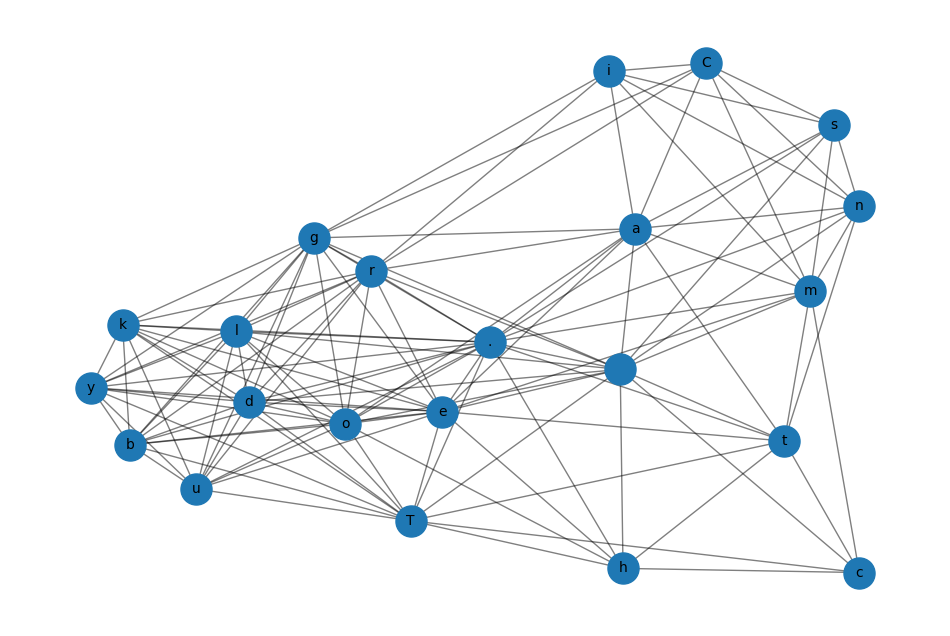

в графе 22 узлов, 122 рёбер
в графе 22 узлов, 105 рёбер после регуляризации
в графе 22 узлов, 105 рёбер после аугментации


Computing transition probabilities:   0%|          | 0/22 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:00<00:00, 129.87it/s]


In [62]:
texts = ["The cat sat on the mat.", "The dog barked loudly.", "Cats and dogs are animals."]
embedder = TextGraphNode2VecEmbedder(similarity_percentile=45)
train_embeddings = embedder.fit_transform(texts)

# Для новых текстов:
new_texts = ["The mat is clean.", "Animals are great."]
test_embeddings = embedder.transform(new_texts)


Узлы (nodes) — это отдельные символы (буквы, знаки препинания и пр.), которые остались после отбора по дисперсии.

Рёбра (edges) — это сильные связи между символами, у которых косинусное сходство выше порога, заданного similarity_percentile.

Количество связей показывает, какие символы чаще встречаются в похожих контекстах в текстах.

Буквы, такие как 't', 'e', 'a', 's', 'o', 'n', часто связаны с другими, потому что:

- Они встречаются в нескольких словах: mat, sat, cat, barked, animals, dog.

- Они имеют схожее "окружение" в терминах n-грамм на уровне символов.

Символ '.' также присутствует, потому что он завершает предложения и встречается во всех строках. Он может быть связан с буквами, с которыми стоит рядом (например, с 't' в "mat." и "barked.").

Связи между 'c', 'a', 't' указывают на частую совместную встречаемость этих символов — например, в слове cat.

In [72]:
texts = train_df['code']
embedder = TextGraphNode2VecEmbedder(
    use_log1p=True,
    embedding_dim=64,
    variance_threshold=0.00025,
    similarity_percentile=5,
    min_sim_threshold=0.07,
    use_preprocessing=True,
    augment_code=False,
    edge_dropout=0.03,
    random_edges=0.03,
    draw_graph=False,
    walk_length=50,
    num_walks=120,
    p=0.8,
    q=1.2,
    workers=12,
)

train_embeddings = embedder.fit_transform(texts)

в графе 96 узлов, 2957 рёбер
в графе 96 узлов, 2870 рёбер после регуляризации


Computing transition probabilities:   0%|          | 0/96 [00:00<?, ?it/s]

In [73]:
val_embeddings = embedder.transform(val_df['code'])
test_embeddings = embedder.transform(test_df['code'])

In [74]:
class CodeLanguageClassifier(nn.Module):
    def __init__(self, input_dim, n_1, n_2, n_3, output_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, n_1)
        self.bn1 = nn.BatchNorm1d(n_1)
        self.fc2 = nn.Linear(n_1, n_2)
        self.bn2 = nn.BatchNorm1d(n_2)
        self.fc3 = nn.Linear(n_2, n_3)
        self.bn3 = nn.BatchNorm1d(n_3)
        self.fc4 = nn.Linear(n_3, output_dim)

        self.fc1_residual = nn.Linear(input_dim, n_1) if input_dim != n_1 else nn.Identity()
        self.fc2_residual = nn.Linear(n_1, n_2) if n_1 != n_2 else nn.Identity()
        self.fc3_residual = nn.Linear(n_2, n_3) if n_2 != n_3 else nn.Identity()

        self.activation = nn.GELU()
        self.dropout = nn.Dropout(p=0.3)

        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, nonlinearity='leaky_relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def forward(self, x):
        identity = self.fc1_residual(x)
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.activation(x)
        x = self.dropout(x + identity)

        identity = self.fc2_residual(x)
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.activation(x)
        x = self.dropout(x + identity)

        identity = self.fc3_residual(x)
        x = self.fc3(x)
        x = self.bn3(x)
        x = self.activation(x)
        x = self.dropout(x + identity)

        return self.fc4(x)

N_1 = 256 * 4
N_2 = 512 * 4
N_3 = 256 * 4

In [75]:
batch_size = 128

train_dataset = TensorDataset(torch.tensor(train_embeddings, dtype=torch.float32), torch.tensor(train_df['label'].to_numpy(), dtype=torch.long))
val_dataset = TensorDataset(torch.tensor(val_embeddings, dtype=torch.float32), torch.tensor(val_df['label'].to_numpy(), dtype=torch.long))
test_dataset = TensorDataset(torch.tensor(test_embeddings, dtype=torch.float32), torch.tensor(test_df['label'].to_numpy(), dtype=torch.long))

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [80]:
input_dim = len(train_embeddings[0])
output_dim = len(lang_counts)

model = CodeLanguageClassifier(input_dim, N_1, N_2, N_3, output_dim).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.002, weight_decay=5e-4)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
#     optimizer,
#     T_max = 100
# )

scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=13,
    gamma=0.33
)

In [81]:
model = train_model(train_loader, val_loader, test_loader, model, criterion, optimizer, scheduler, epochs=100, log_every=5, early_stopping_patience=8)

Training:   5%|▌         | 5/100 [00:09<02:55,  1.84s/it, train_loss=1.1835, val_loss=1.2896, val_f1=0.5867]

Epoch: 5/100 |  Val Loss: 1.2896 | Train F1: 0.6166 | Val F1: 0.5867


Training:  10%|█         | 10/100 [00:18<02:44,  1.83s/it, train_loss=1.1024, val_loss=1.2882, val_f1=0.6078]

Epoch: 10/100 |  Val Loss: 1.2882 | Train F1: 0.6410 | Val F1: 0.6078


Training:  15%|█▌        | 15/100 [00:27<02:36,  1.84s/it, train_loss=0.7455, val_loss=0.7730, val_f1=0.7259]

Epoch: 15/100 |  Val Loss: 0.7730 | Train F1: 0.7319 | Val F1: 0.7259


Training:  20%|██        | 20/100 [00:36<02:28,  1.86s/it, train_loss=0.7071, val_loss=0.7473, val_f1=0.7368]

Epoch: 20/100 |  Val Loss: 0.7473 | Train F1: 0.7446 | Val F1: 0.7368


Training:  25%|██▌       | 25/100 [00:46<02:17,  1.83s/it, train_loss=0.6775, val_loss=0.7634, val_f1=0.7381]

Epoch: 25/100 |  Val Loss: 0.7634 | Train F1: 0.7568 | Val F1: 0.7381


Training:  30%|███       | 30/100 [00:55<02:08,  1.83s/it, train_loss=0.5112, val_loss=0.6482, val_f1=0.7760]

Epoch: 30/100 |  Val Loss: 0.6482 | Train F1: 0.8096 | Val F1: 0.7760


Training:  35%|███▌      | 35/100 [01:04<01:58,  1.83s/it, train_loss=0.4812, val_loss=0.6530, val_f1=0.7807]

Epoch: 35/100 |  Val Loss: 0.6530 | Train F1: 0.8199 | Val F1: 0.7807


Training:  40%|████      | 40/100 [01:13<01:49,  1.83s/it, train_loss=0.4266, val_loss=0.6204, val_f1=0.7905]

Epoch: 40/100 |  Val Loss: 0.6204 | Train F1: 0.8408 | Val F1: 0.7905


Training:  45%|████▌     | 45/100 [01:22<01:40,  1.83s/it, train_loss=0.4001, val_loss=0.6306, val_f1=0.7962]

Epoch: 45/100 |  Val Loss: 0.6306 | Train F1: 0.8509 | Val F1: 0.7962


Training:  50%|█████     | 50/100 [01:31<01:31,  1.83s/it, train_loss=0.3837, val_loss=0.6285, val_f1=0.7933]

Epoch: 50/100 |  Val Loss: 0.6285 | Train F1: 0.8592 | Val F1: 0.7933


Training:  55%|█████▌    | 55/100 [01:40<01:21,  1.82s/it, train_loss=0.3596, val_loss=0.6251, val_f1=0.7943]

Epoch: 55/100 |  Val Loss: 0.6251 | Train F1: 0.8669 | Val F1: 0.7943


Training:  60%|██████    | 60/100 [01:49<01:12,  1.82s/it, train_loss=0.3553, val_loss=0.6331, val_f1=0.7950]

Epoch: 60/100 |  Val Loss: 0.6331 | Train F1: 0.8660 | Val F1: 0.7950


Training:  64%|██████▍   | 64/100 [01:59<01:06,  1.86s/it, train_loss=0.3466, val_loss=0.6304, val_f1=0.7933]


Early stopping at epoch 65



Final Test Metrics:
Test Loss: 0.6159 | Test F1: 0.7971

Classification report on test
              precision    recall  f1-score   support

           R       1.00      0.25      0.40         8
           c       0.71      0.59      0.64       230
 c-plus-plus       0.76      0.85      0.81       537
     c-sharp       0.77      0.73      0.75       199
        dart       0.63      0.48      0.55        50
     f-sharp       0.70      0.70      0.70        10
          go       0.82      0.82      0.82        94
        java       0.77      0.61      0.68       214
  javascript       0.73      0.73      0.73       129
       julia       0.94      0.76      0.84        45
         php       0.87      0.87      0.87        15
      python       0.94      0.96      0.95       663
        ruby       0.46      0.80      0.58        64
       scala       0.83      0.83      0.83         6
       swift       0.83      0.56      0.67        18

    accuracy                           0.80   

In [82]:
def predict_single(model,embedder,code_snippet,device=None,show_time=False):
    start_time = time.time() if show_time else None

    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    embedding = embedder.transform([code_snippet])[0]

    input_tensor = torch.tensor(embedding, dtype=torch.float32).unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        outputs = model(input_tensor)
        probs = torch.softmax(outputs, dim=1)
        _, pred_class = torch.max(outputs, 1)

    if show_time:
        infer_time = time.time() - start_time
        print(f"Inference time: {infer_time}")

    return pred_class.item()

In [83]:
new_code = """
def fibonacci(n):
    a, b = 0, 1
    for _ in range(n):
        yield a
        a, b = b, a + b
"""

pred_class = predict_single(
    model=model,
    embedder=embedder,
    code_snippet=new_code,
    show_time=True
)

print(f"Predicted class: {label_to_language[pred_class]}")

Inference time: 0.004998922348022461
Predicted class: python


In [ ]:
def full_pipeline(embedder, N_1, N_2, N_3, lr, weight_decay, step_size, gamma):
    texts = train_df['code']
    train_embeddings = embedder.fit_transform(texts)
    val_embeddings = embedder.transform(val_df['code'])
    test_embeddings = embedder.transform(test_df['code'])

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    batch_size = 128

    train_dataset = TensorDataset(torch.tensor(train_embeddings, dtype=torch.float32), torch.tensor(train_df['label'].to_numpy(), dtype=torch.long))
    val_dataset = TensorDataset(torch.tensor(val_embeddings, dtype=torch.float32), torch.tensor(val_df['label'].to_numpy(), dtype=torch.long))
    test_dataset = TensorDataset(torch.tensor(test_embeddings, dtype=torch.float32), torch.tensor(test_df['label'].to_numpy(), dtype=torch.long))

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    input_dim = len(train_embeddings[0])
    output_dim = len(lang_counts)

    model = CodeLanguageClassifier(input_dim, N_1, N_2, N_3, output_dim)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    # scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    #     optimizer,
    #     T_max = 100
    # )

    scheduler = torch.optim.lr_scheduler.StepLR(
        optimizer,
        step_size=step_size,
        gamma=gamma
    )

    model = train_model(train_loader, val_loader, test_loader, model, criterion, optimizer, scheduler, epochs=100, log_every=5, early_stopping_patience=8, draw_met=False, draw_tqdm=False)

    model.eval()
    all_test_preds = []
    all_test_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:  # Или test_loader, если он доступен
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            _, preds = torch.max(outputs, 1)
            all_test_preds.extend(preds.cpu().numpy())
            all_test_labels.extend(labels.cpu().numpy())

    test_f1 = f1_score(all_test_labels, all_test_preds, average='weighted')

    return test_f1

In [ ]:
def objective(trial):
    embedder = TextGraphNode2VecEmbedder(
        use_log1p=trial.suggest_categorical('use_log1p', [True, False]),
        embedding_dim=trial.suggest_categorical('embedding_dim', [64, 128, 256]),
        variance_threshold=trial.suggest_float('variance_threshold', 0.00001, 0.0005, log=True),
        similarity_percentile=trial.suggest_int('similarity_percentile', 5, 35),
        min_sim_threshold=trial.suggest_float('min_sim_threshold', 0.01, 0.1),
        use_preprocessing=True,
        augment_code=False,
        edge_dropout=trial.suggest_float('edge_dropout', 0.0, 0.1),
        random_edges=trial.suggest_float('random_edges', 0.0, 0.1),
        verbose=False,
        draw_graph=False,
        walk_length=trial.suggest_int('walk_length', 20, 100),
        num_walks=trial.suggest_int('num_walks', 50, 150),
        p=trial.suggest_float('p', 0.5, 2.0),
        q=trial.suggest_float('q', 0.5, 2.0),
        workers=12,
    )

    N_1 = trial.suggest_int("N_1", 128, 512)
    N_2 = trial.suggest_int("N_2", 64, 256)
    N_3 = trial.suggest_int("N_3", 32, 128)

    lr = trial.suggest_float("lr", 1e-4, 5e-3, log=True)
    weight_decay = trial.suggest_float("weight_decay", 0.0, 1e-2)
    step_size = trial.suggest_int("step_size", 5, 20)
    gamma = trial.suggest_float("gamma", 0.2, 0.9)

    try:
        f1 = full_pipeline(embedder, N_1, N_2, N_3, lr, weight_decay, step_size, gamma)
        return f1
    except RuntimeError as e:
        print(f"[Trial {trial.number}] Skipped: {e}")
        return 0.0

In [ ]:
study = optuna.create_study(
    direction="maximize",
    sampler=TPESampler(seed=42)
)

study.optimize(objective, n_trials=100)


[I 2025-05-22 02:10:59,065] A new study created in memory with name: no-name-0e0de016-2411-4cab-b2c7-3c5201091a81


Computing transition probabilities:   0%|          | 0/136 [00:00<?, ?it/s]

[I 2025-05-22 02:12:38,128] Trial 0 finished with value: 0.7148628264184331 and parameters: {'use_log1p': False, 'embedding_dim': 64, 'variance_threshold': 1.8408992080552506e-05, 'similarity_percentile': 6, 'min_sim_threshold': 0.08795585311974417, 'edge_dropout': 0.06011150117432088, 'random_edges': 0.07080725777960455, 'walk_length': 21, 'num_walks': 147, 'p': 1.7486639612006325, 'q': 0.8185086660174142, 'N_1': 198, 'N_2': 99, 'N_3': 61, 'lr': 0.0007790143126276247, 'weight_decay': 0.004319450186421158, 'step_size': 9, 'gamma': 0.6282970263056656}. Best is trial 0 with value: 0.7148628264184331.



Early stopping at epoch 67


Computing transition probabilities:   0%|          | 0/126 [00:00<?, ?it/s]

[I 2025-05-22 02:14:04,640] Trial 1 finished with value: 0.7180278034926504 and parameters: {'use_log1p': False, 'embedding_dim': 256, 'variance_threshold': 2.1839352923182963e-05, 'similarity_percentile': 20, 'min_sim_threshold': 0.06331731119758383, 'edge_dropout': 0.0046450412719997725, 'random_edges': 0.06075448519014384, 'walk_length': 33, 'num_walks': 56, 'p': 1.92332830588, 'q': 1.948448049611839, 'N_1': 439, 'N_2': 122, 'N_3': 41, 'lr': 0.0014537555576161927, 'weight_decay': 0.004401524937396013, 'step_size': 6, 'gamma': 0.5466238370778891}. Best is trial 1 with value: 0.7180278034926504.



Early stopping at epoch 55


Computing transition probabilities:   0%|          | 0/101 [00:00<?, ?it/s]

[I 2025-05-22 02:16:05,712] Trial 2 finished with value: 0.7247171402160336 and parameters: {'use_log1p': False, 'embedding_dim': 128, 'variance_threshold': 7.648565112369947e-05, 'similarity_percentile': 21, 'min_sim_threshold': 0.026636900997297437, 'edge_dropout': 0.09695846277645587, 'random_edges': 0.07751328233611146, 'walk_length': 96, 'num_walks': 140, 'p': 1.3968499682166278, 'q': 1.8828113525346752, 'N_1': 162, 'N_2': 101, 'N_3': 36, 'lr': 0.0003570478920909981, 'weight_decay': 0.0038867728968948203, 'step_size': 9, 'gamma': 0.7801162564063504}. Best is trial 2 with value: 0.7247171402160336.



Early stopping at epoch 79


Computing transition probabilities:   0%|          | 0/155 [00:00<?, ?it/s]

[I 2025-05-22 02:17:30,315] Trial 3 finished with value: 0.7374381673193615 and parameters: {'use_log1p': True, 'embedding_dim': 256, 'variance_threshold': 1.3386261584543902e-05, 'similarity_percentile': 35, 'min_sim_threshold': 0.07950202923669918, 'edge_dropout': 0.019871568153417243, 'random_edges': 0.00055221171236024, 'walk_length': 86, 'num_walks': 121, 'p': 1.5935107520614809, 'q': 1.6569055200289187, 'N_1': 156, 'N_2': 133, 'N_3': 43, 'lr': 0.002926758115062129, 'weight_decay': 0.006232981268275579, 'step_size': 10, 'gamma': 0.24449084520021655}. Best is trial 3 with value: 0.7374381673193615.



Early stopping at epoch 49


Computing transition probabilities:   0%|          | 0/101 [00:00<?, ?it/s]

[I 2025-05-22 02:17:54,665] Trial 4 finished with value: 0.6280147770861485 and parameters: {'use_log1p': False, 'embedding_dim': 256, 'variance_threshold': 6.342770438858346e-05, 'similarity_percentile': 8, 'min_sim_threshold': 0.07419203085006955, 'edge_dropout': 0.07607850486168975, 'random_edges': 0.05612771975694963, 'walk_length': 82, 'num_walks': 99, 'p': 1.284099244072991, 'q': 1.1413115275378245, 'N_1': 137, 'N_2': 84, 'N_3': 35, 'lr': 0.0012057081573389123, 'weight_decay': 0.0031435598107632666, 'step_size': 13, 'gamma': 0.835296531748265}. Best is trial 3 with value: 0.7374381673193615.



Early stopping at epoch 12


Computing transition probabilities:   0%|          | 0/116 [00:00<?, ?it/s]

[I 2025-05-22 02:19:22,017] Trial 5 finished with value: 0.6938198006451589 and parameters: {'use_log1p': False, 'embedding_dim': 64, 'variance_threshold': 3.10655485858191e-05, 'similarity_percentile': 9, 'min_sim_threshold': 0.09367278871083158, 'edge_dropout': 0.0808120379564417, 'random_edges': 0.06334037565104235, 'walk_length': 90, 'num_walks': 131, 'p': 0.7798550883290538, 'q': 1.8388384977349665, 'N_1': 335, 'N_2': 219, 'N_3': 118, 'lr': 0.00034695916603302916, 'weight_decay': 0.0011005192452767675, 'step_size': 8, 'gamma': 0.4989754520383794}. Best is trial 3 with value: 0.7374381673193615.



Early stopping at epoch 55


Computing transition probabilities:   0%|          | 0/127 [00:00<?, ?it/s]

[I 2025-05-22 02:20:49,168] Trial 6 finished with value: 0.7215843532000655 and parameters: {'use_log1p': False, 'embedding_dim': 128, 'variance_threshold': 2.3842649129817383e-05, 'similarity_percentile': 8, 'min_sim_threshold': 0.04038536542632652, 'edge_dropout': 0.09429097039125192, 'random_edges': 0.03232029320207552, 'walk_length': 62, 'num_walks': 121, 'p': 1.045444403568941, 'q': 1.957673124081441, 'N_1': 498, 'N_2': 112, 'N_3': 80, 'lr': 0.000324476480988986, 'weight_decay': 0.002848404943774676, 'step_size': 5, 'gamma': 0.6266950337859278}. Best is trial 3 with value: 0.7374381673193615.



Early stopping at epoch 55


Computing transition probabilities:   0%|          | 0/135 [00:00<?, ?it/s]

C:\Users\yarom\AppData\Local\Temp\ipykernel_17556\2663798661.py:98: RuntimeWarning:

invalid value encountered in log1p

[I 2025-05-22 02:21:07,357] Trial 7 finished with value: 2.449395114222183e-05 and parameters: {'use_log1p': True, 'embedding_dim': 128, 'variance_threshold': 1.7626741740706325e-05, 'similarity_percentile': 20, 'min_sim_threshold': 0.09870854086995406, 'edge_dropout': 0.02420552715115004, 'random_edges': 0.06721355474058786, 'walk_length': 81, 'num_walks': 74, 'p': 1.5923245229177894, 'q': 1.05167469907888, 'N_1': 371, 'N_2': 186, 'N_3': 83, 'lr': 0.0001423638128723575, 'weight_decay': 0.00835302495589238, 'step_size': 10, 'gamma': 0.33056295727989793}. Best is trial 3 with value: 0.7374381673193615.



Early stopping at epoch 9


Computing transition probabilities:   0%|          | 0/128 [00:00<?, ?it/s]

[I 2025-05-22 02:22:47,868] Trial 8 finished with value: 0.771950181325296 and parameters: {'use_log1p': False, 'embedding_dim': 64, 'variance_threshold': 2.425546071605744e-05, 'similarity_percentile': 25, 'min_sim_threshold': 0.02569297861044923, 'edge_dropout': 0.0690937738102466, 'random_edges': 0.03867353463005374, 'walk_length': 95, 'num_walks': 63, 'p': 1.0115995265753877, 'q': 0.6702102818608836, 'N_1': 484, 'N_2': 233, 'N_3': 57, 'lr': 0.0013221876538695291, 'weight_decay': 0.008172222002012158, 'step_size': 13, 'gamma': 0.5707554048492045}. Best is trial 8 with value: 0.771950181325296.



Early stopping at epoch 64


Computing transition probabilities:   0%|          | 0/107 [00:00<?, ?it/s]

C:\Users\yarom\AppData\Local\Temp\ipykernel_17556\2663798661.py:98: RuntimeWarning:

invalid value encountered in log1p

[I 2025-05-22 02:23:07,187] Trial 9 finished with value: 2.449395114222183e-05 and parameters: {'use_log1p': True, 'embedding_dim': 128, 'variance_threshold': 3.7670505286095635e-05, 'similarity_percentile': 15, 'min_sim_threshold': 0.07533601109832154, 'edge_dropout': 0.08971102599525771, 'random_edges': 0.08870864242651173, 'walk_length': 83, 'num_walks': 114, 'p': 0.6262099474925733, 'q': 0.7424430711419207, 'N_1': 473, 'N_2': 181, 'N_3': 32, 'lr': 0.00014872949647124203, 'weight_decay': 0.006635017691080558, 'step_size': 5, 'gamma': 0.31256563599224907}. Best is trial 8 with value: 0.771950181325296.



Early stopping at epoch 9


Computing transition probabilities:   0%|          | 0/96 [00:00<?, ?it/s]

[I 2025-05-22 02:24:03,583] Trial 10 finished with value: 0.7055354092066498 and parameters: {'use_log1p': True, 'embedding_dim': 64, 'variance_threshold': 0.0002818535465134846, 'similarity_percentile': 31, 'min_sim_threshold': 0.011435245221061638, 'edge_dropout': 0.052387777421490506, 'random_edges': 0.03613119964418094, 'walk_length': 54, 'num_walks': 83, 'p': 1.0602413943371638, 'q': 0.5410833231194881, 'N_1': 265, 'N_2': 242, 'N_3': 70, 'lr': 0.004781796419672867, 'weight_decay': 0.009355618760814248, 'step_size': 18, 'gamma': 0.40099826702114166}. Best is trial 8 with value: 0.771950181325296.



Early stopping at epoch 36


Computing transition probabilities:   0%|          | 0/168 [00:00<?, ?it/s]

C:\Users\yarom\AppData\Local\Temp\ipykernel_17556\2663798661.py:98: RuntimeWarning:

invalid value encountered in log1p

[I 2025-05-22 02:24:24,778] Trial 11 finished with value: 2.449395114222183e-05 and parameters: {'use_log1p': True, 'embedding_dim': 256, 'variance_threshold': 1.235113234823365e-05, 'similarity_percentile': 35, 'min_sim_threshold': 0.04281772986820011, 'edge_dropout': 0.03347210834763121, 'random_edges': 0.0053971563728927585, 'walk_length': 100, 'num_walks': 50, 'p': 1.0141989323994745, 'q': 1.5158757753145318, 'N_1': 256, 'N_2': 148, 'N_3': 54, 'lr': 0.0033315037552718928, 'weight_decay': 0.006634064286119826, 'step_size': 14, 'gamma': 0.22428102453122167}. Best is trial 8 with value: 0.771950181325296.



Early stopping at epoch 9


Computing transition probabilities:   0%|          | 0/173 [00:00<?, ?it/s]

[I 2025-05-22 02:25:12,034] Trial 12 finished with value: 0.6557166796471535 and parameters: {'use_log1p': True, 'embedding_dim': 256, 'variance_threshold': 1.1316764643394993e-05, 'similarity_percentile': 28, 'min_sim_threshold': 0.0476080742258026, 'edge_dropout': 0.03107436211884783, 'random_edges': 0.002984298933809846, 'walk_length': 67, 'num_walks': 101, 'p': 1.496926956522177, 'q': 1.492655321925946, 'N_1': 399, 'N_2': 149, 'N_3': 51, 'lr': 0.002191361227834792, 'weight_decay': 0.006840011181233008, 'step_size': 16, 'gamma': 0.6815115066310107}. Best is trial 8 with value: 0.771950181325296.



Early stopping at epoch 25


Computing transition probabilities:   0%|          | 0/104 [00:00<?, ?it/s]

C:\Users\yarom\AppData\Local\Temp\ipykernel_17556\2663798661.py:98: RuntimeWarning:

invalid value encountered in log1p

[I 2025-05-22 02:25:30,224] Trial 13 finished with value: 2.449395114222183e-05 and parameters: {'use_log1p': True, 'embedding_dim': 64, 'variance_threshold': 6.039037404403274e-05, 'similarity_percentile': 28, 'min_sim_threshold': 0.010532502215736934, 'edge_dropout': 0.002635087081732629, 'random_edges': 0.02268230686373274, 'walk_length': 69, 'num_walks': 74, 'p': 1.7019531338160612, 'q': 1.413437420599407, 'N_1': 247, 'N_2': 208, 'N_3': 98, 'lr': 0.0022499450099113176, 'weight_decay': 0.008139937055778318, 'step_size': 11, 'gamma': 0.5139033149179736}. Best is trial 8 with value: 0.771950181325296.



Early stopping at epoch 9


Computing transition probabilities:   0%|          | 0/96 [00:00<?, ?it/s]

[I 2025-05-22 02:26:35,395] Trial 14 finished with value: 0.7512764117631574 and parameters: {'use_log1p': False, 'embedding_dim': 256, 'variance_threshold': 0.00015615996478814633, 'similarity_percentile': 34, 'min_sim_threshold': 0.02631616762525047, 'edge_dropout': 0.06560438344215366, 'random_edges': 0.01993965435111975, 'walk_length': 77, 'num_walks': 100, 'p': 1.2165852913039517, 'q': 1.669142303467518, 'N_1': 309, 'N_2': 255, 'N_3': 63, 'lr': 0.000797018168468066, 'weight_decay': 0.0058222092811753895, 'step_size': 20, 'gamma': 0.42428386310353994}. Best is trial 8 with value: 0.771950181325296.



Early stopping at epoch 39


Computing transition probabilities:   0%|          | 0/97 [00:00<?, ?it/s]

[I 2025-05-22 02:28:49,916] Trial 15 finished with value: 0.7551263677690055 and parameters: {'use_log1p': False, 'embedding_dim': 64, 'variance_threshold': 0.00020616601185545835, 'similarity_percentile': 25, 'min_sim_threshold': 0.029404784764878938, 'edge_dropout': 0.0660342196618576, 'random_edges': 0.03899471750610508, 'walk_length': 49, 'num_walks': 90, 'p': 0.8621169536520208, 'q': 0.9219982752797572, 'N_1': 312, 'N_2': 251, 'N_3': 69, 'lr': 0.0007988141360317723, 'weight_decay': 0.009831163966501287, 'step_size': 20, 'gamma': 0.4326573517623165}. Best is trial 8 with value: 0.771950181325296.



Early stopping at epoch 90


Computing transition probabilities:   0%|          | 0/94 [00:00<?, ?it/s]

[I 2025-05-22 02:30:57,880] Trial 16 finished with value: 0.7325456199370878 and parameters: {'use_log1p': False, 'embedding_dim': 64, 'variance_threshold': 0.0004436873104901397, 'similarity_percentile': 25, 'min_sim_threshold': 0.027625230937399846, 'edge_dropout': 0.04770869527236186, 'random_edges': 0.04445988521282485, 'walk_length': 48, 'num_walks': 63, 'p': 0.804414009707489, 'q': 0.9398210691866424, 'N_1': 412, 'N_2': 222, 'N_3': 95, 'lr': 0.0005598963195965014, 'weight_decay': 0.009920372488824094, 'step_size': 16, 'gamma': 0.4470196498123761}. Best is trial 8 with value: 0.771950181325296.



Early stopping at epoch 86


Computing transition probabilities:   0%|          | 0/99 [00:00<?, ?it/s]

[I 2025-05-22 02:31:59,031] Trial 17 finished with value: 0.7197909745145216 and parameters: {'use_log1p': False, 'embedding_dim': 64, 'variance_threshold': 0.00012108824161140818, 'similarity_percentile': 16, 'min_sim_threshold': 0.05743577080512454, 'edge_dropout': 0.07162330641997615, 'random_edges': 0.046622377276602976, 'walk_length': 41, 'num_walks': 86, 'p': 0.529786475909294, 'q': 0.5088917385634038, 'N_1': 329, 'N_2': 240, 'N_3': 75, 'lr': 0.0013590979756247462, 'weight_decay': 0.007970130536751842, 'step_size': 20, 'gamma': 0.6947793482022958}. Best is trial 8 with value: 0.771950181325296.



Early stopping at epoch 39


Computing transition probabilities:   0%|          | 0/97 [00:00<?, ?it/s]

[I 2025-05-22 02:33:49,397] Trial 18 finished with value: 0.7033455115184549 and parameters: {'use_log1p': False, 'embedding_dim': 64, 'variance_threshold': 0.00021473084566655143, 'similarity_percentile': 24, 'min_sim_threshold': 0.03369859998459759, 'edge_dropout': 0.04642677339214557, 'random_edges': 0.029166642509274622, 'walk_length': 36, 'num_walks': 71, 'p': 0.8640919717983374, 'q': 0.7122730863120029, 'N_1': 361, 'N_2': 195, 'N_3': 89, 'lr': 0.0005299274209712921, 'weight_decay': 0.009189585863011236, 'step_size': 15, 'gamma': 0.3485577665869018}. Best is trial 8 with value: 0.771950181325296.



Early stopping at epoch 71


Computing transition probabilities:   0%|          | 0/93 [00:00<?, ?it/s]

[I 2025-05-22 02:35:57,326] Trial 19 finished with value: 0.7689397128831116 and parameters: {'use_log1p': False, 'embedding_dim': 64, 'variance_threshold': 0.0004883837497313047, 'similarity_percentile': 16, 'min_sim_threshold': 0.019152921262934837, 'edge_dropout': 0.08153388462026802, 'random_edges': 0.04252705898524161, 'walk_length': 53, 'num_walks': 88, 'p': 1.2029976301367722, 'q': 1.2571276097894095, 'N_1': 297, 'N_2': 254, 'N_3': 111, 'lr': 0.0010513651326308228, 'weight_decay': 0.00773429103191896, 'step_size': 18, 'gamma': 0.6128550111544565}. Best is trial 8 with value: 0.771950181325296.



Early stopping at epoch 84


Computing transition probabilities:   0%|          | 0/94 [00:00<?, ?it/s]

[I 2025-05-22 02:38:10,125] Trial 20 finished with value: 0.7880002088509511 and parameters: {'use_log1p': False, 'embedding_dim': 64, 'variance_threshold': 0.00044245496454078606, 'similarity_percentile': 14, 'min_sim_threshold': 0.015376453514903047, 'edge_dropout': 0.08202641457605576, 'random_edges': 0.013116240841328012, 'walk_length': 72, 'num_walks': 68, 'p': 1.1744820628350539, 'q': 1.2952285393967964, 'N_1': 453, 'N_2': 223, 'N_3': 123, 'lr': 0.0011652985230152302, 'weight_decay': 0.007376571444784036, 'step_size': 18, 'gamma': 0.6203143578867735}. Best is trial 20 with value: 0.7880002088509511.



Early stopping at epoch 86


Computing transition probabilities:   0%|          | 0/94 [00:00<?, ?it/s]

[I 2025-05-22 02:38:58,323] Trial 21 finished with value: 0.7343890109554186 and parameters: {'use_log1p': False, 'embedding_dim': 64, 'variance_threshold': 0.0004010332162254877, 'similarity_percentile': 13, 'min_sim_threshold': 0.01771925973793675, 'edge_dropout': 0.08183043018089489, 'random_edges': 0.014812885658864582, 'walk_length': 73, 'num_walks': 64, 'p': 1.1942342583332153, 'q': 1.2591977175782842, 'N_1': 505, 'N_2': 230, 'N_3': 117, 'lr': 0.001322379592240749, 'weight_decay': 0.007416753096549353, 'step_size': 18, 'gamma': 0.5943023309507548}. Best is trial 20 with value: 0.7880002088509511.



Early stopping at epoch 29


Computing transition probabilities:   0%|          | 0/94 [00:00<?, ?it/s]

[I 2025-05-22 02:39:50,404] Trial 22 finished with value: 0.7286259152576648 and parameters: {'use_log1p': False, 'embedding_dim': 64, 'variance_threshold': 0.0003833097434312799, 'similarity_percentile': 12, 'min_sim_threshold': 0.01871407984340498, 'edge_dropout': 0.08542040740630383, 'random_edges': 0.015288132308721097, 'walk_length': 59, 'num_walks': 79, 'p': 1.3374107962916437, 'q': 1.2696573471786332, 'N_1': 455, 'N_2': 210, 'N_3': 127, 'lr': 0.0010475712797606393, 'weight_decay': 0.005667705790618774, 'step_size': 18, 'gamma': 0.7472318224588689}. Best is trial 20 with value: 0.7880002088509511.



Early stopping at epoch 32


Computing transition probabilities:   0%|          | 0/96 [00:00<?, ?it/s]

[I 2025-05-22 02:41:29,282] Trial 23 finished with value: 0.7736269489087648 and parameters: {'use_log1p': False, 'embedding_dim': 64, 'variance_threshold': 0.00026329488661533683, 'similarity_percentile': 17, 'min_sim_threshold': 0.019614668117527614, 'edge_dropout': 0.09989716120622515, 'random_edges': 0.04723380380927297, 'walk_length': 63, 'num_walks': 63, 'p': 1.1286267962131304, 'q': 1.3664173132054396, 'N_1': 431, 'N_2': 175, 'N_3': 113, 'lr': 0.0016370131126515542, 'weight_decay': 0.008425242159925028, 'step_size': 17, 'gamma': 0.5821754993625502}. Best is trial 20 with value: 0.7880002088509511.



Early stopping at epoch 64


Computing transition probabilities:   0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-05-22 02:42:11,981] Trial 24 finished with value: 0.723789185791516 and parameters: {'use_log1p': False, 'embedding_dim': 64, 'variance_threshold': 0.00010123463721386219, 'similarity_percentile': 18, 'min_sim_threshold': 0.03535261433046656, 'edge_dropout': 0.09777495922601406, 'random_edges': 0.049471556223172314, 'walk_length': 93, 'num_walks': 58, 'p': 0.9727811416514144, 'q': 1.3994718639495103, 'N_1': 423, 'N_2': 171, 'N_3': 106, 'lr': 0.0020610500704720744, 'weight_decay': 0.008572624249815334, 'step_size': 16, 'gamma': 0.8923001425589824}. Best is trial 20 with value: 0.7880002088509511.



Early stopping at epoch 26


Computing transition probabilities:   0%|          | 0/110 [00:00<?, ?it/s]

[I 2025-05-22 02:44:43,831] Trial 25 finished with value: 0.77572503827482 and parameters: {'use_log1p': False, 'embedding_dim': 64, 'variance_threshold': 4.107170799266078e-05, 'similarity_percentile': 23, 'min_sim_threshold': 0.020287420497878676, 'edge_dropout': 0.07089259599826937, 'random_edges': 0.054731428549212605, 'walk_length': 63, 'num_walks': 67, 'p': 1.1301385744131456, 'q': 1.15656208095333, 'N_1': 477, 'N_2': 199, 'N_3': 122, 'lr': 0.0018504087963992079, 'weight_decay': 0.008916396598935193, 'step_size': 12, 'gamma': 0.6985256238074123}. Best is trial 20 with value: 0.7880002088509511.


Computing transition probabilities:   0%|          | 0/110 [00:00<?, ?it/s]

[I 2025-05-22 02:46:17,357] Trial 26 finished with value: 0.7609286610465632 and parameters: {'use_log1p': False, 'embedding_dim': 64, 'variance_threshold': 4.519154159948382e-05, 'similarity_percentile': 22, 'min_sim_threshold': 0.017526531727763986, 'edge_dropout': 0.08955849826251612, 'random_edges': 0.08071779025094111, 'walk_length': 62, 'num_walks': 51, 'p': 1.4417567241597637, 'q': 1.1042088781585377, 'N_1': 449, 'N_2': 166, 'N_3': 126, 'lr': 0.0018145071697724699, 'weight_decay': 0.008958254314269587, 'step_size': 12, 'gamma': 0.6934046008159158}. Best is trial 20 with value: 0.7880002088509511.



Early stopping at epoch 61


Computing transition probabilities:   0%|          | 0/96 [00:00<?, ?it/s]

[I 2025-05-22 02:47:20,628] Trial 27 finished with value: 0.7183344738688477 and parameters: {'use_log1p': False, 'embedding_dim': 64, 'variance_threshold': 0.00028156592706593645, 'similarity_percentile': 12, 'min_sim_threshold': 0.04696444654218558, 'edge_dropout': 0.09998807247077306, 'random_edges': 0.054497049285876904, 'walk_length': 73, 'num_walks': 72, 'p': 1.1345601390509672, 'q': 1.37340875478344, 'N_1': 391, 'N_2': 199, 'N_3': 105, 'lr': 0.0030614788145289615, 'weight_decay': 0.007371127569878409, 'step_size': 14, 'gamma': 0.7623590731107218}. Best is trial 20 with value: 0.7880002088509511.



Early stopping at epoch 41


Computing transition probabilities:   0%|          | 0/96 [00:00<?, ?it/s]

[I 2025-05-22 02:47:50,025] Trial 28 finished with value: 0.6155440632712198 and parameters: {'use_log1p': False, 'embedding_dim': 64, 'variance_threshold': 0.00028570519342742423, 'similarity_percentile': 18, 'min_sim_threshold': 0.012763236850787046, 'edge_dropout': 0.05686037951618095, 'random_edges': 0.02676776122344222, 'walk_length': 66, 'num_walks': 66, 'p': 1.1284341985821955, 'q': 1.6558290777549474, 'N_1': 512, 'N_2': 180, 'N_3': 119, 'lr': 0.004810993310074862, 'weight_decay': 0.005472658858444628, 'step_size': 17, 'gamma': 0.6624015774647202}. Best is trial 20 with value: 0.7880002088509511.



Early stopping at epoch 17


Computing transition probabilities:   0%|          | 0/97 [00:00<?, ?it/s]

[I 2025-05-22 02:49:44,365] Trial 29 finished with value: 0.7438955397578001 and parameters: {'use_log1p': False, 'embedding_dim': 64, 'variance_threshold': 0.00015305559249264656, 'similarity_percentile': 18, 'min_sim_threshold': 0.03704133439017418, 'edge_dropout': 0.0768682975629779, 'random_edges': 0.0740544766962588, 'walk_length': 58, 'num_walks': 93, 'p': 0.9215155765939558, 'q': 1.1504814723616832, 'N_1': 468, 'N_2': 157, 'N_3': 109, 'lr': 0.0006667949428843452, 'weight_decay': 0.007169552818749947, 'step_size': 12, 'gamma': 0.5051914506490978}. Best is trial 20 with value: 0.7880002088509511.



Early stopping at epoch 72


Computing transition probabilities:   0%|          | 0/105 [00:00<?, ?it/s]

[I 2025-05-22 02:50:13,876] Trial 30 finished with value: 0.6010582233177012 and parameters: {'use_log1p': False, 'embedding_dim': 128, 'variance_threshold': 4.795342144907636e-05, 'similarity_percentile': 5, 'min_sim_threshold': 0.058906855298649, 'edge_dropout': 0.059810946364552704, 'random_edges': 0.054861390321557554, 'walk_length': 26, 'num_walks': 78, 'p': 0.6700509706760457, 'q': 0.9874368950433867, 'N_1': 423, 'N_2': 197, 'N_3': 122, 'lr': 0.0017618828335626735, 'weight_decay': 0.008889198322859225, 'step_size': 19, 'gamma': 0.8248928194367416}. Best is trial 20 with value: 0.7880002088509511.



Early stopping at epoch 17


Computing transition probabilities:   0%|          | 0/118 [00:00<?, ?it/s]

[I 2025-05-22 02:52:01,294] Trial 31 finished with value: 0.7627548897024665 and parameters: {'use_log1p': False, 'embedding_dim': 64, 'variance_threshold': 3.181941218555613e-05, 'similarity_percentile': 23, 'min_sim_threshold': 0.019901850110449426, 'edge_dropout': 0.07221494597932726, 'random_edges': 0.036376006644902786, 'walk_length': 75, 'num_walks': 57, 'p': 1.0956619276923216, 'q': 0.8364516205738781, 'N_1': 481, 'N_2': 227, 'N_3': 99, 'lr': 0.0008850965807476995, 'weight_decay': 0.008246584129619074, 'step_size': 14, 'gamma': 0.5612581771723676}. Best is trial 20 with value: 0.7880002088509511.



Early stopping at epoch 69


Computing transition probabilities:   0%|          | 0/136 [00:00<?, ?it/s]

[I 2025-05-22 02:52:38,087] Trial 32 finished with value: 0.7026775141078772 and parameters: {'use_log1p': False, 'embedding_dim': 64, 'variance_threshold': 2.028168820370689e-05, 'similarity_percentile': 28, 'min_sim_threshold': 0.02445994945816926, 'edge_dropout': 0.08954963990847634, 'random_edges': 0.05875258850032092, 'walk_length': 43, 'num_walks': 66, 'p': 1.3147511290638012, 'q': 1.525048393350952, 'N_1': 440, 'N_2': 211, 'N_3': 113, 'lr': 0.0015921412998572031, 'weight_decay': 0.0096299917070719, 'step_size': 13, 'gamma': 0.5807675815044396}. Best is trial 20 with value: 0.7880002088509511.



Early stopping at epoch 22


Computing transition probabilities:   0%|          | 0/123 [00:00<?, ?it/s]

[I 2025-05-22 02:54:28,014] Trial 33 finished with value: 0.7750687434454997 and parameters: {'use_log1p': False, 'embedding_dim': 64, 'variance_threshold': 2.5666863490800514e-05, 'similarity_percentile': 26, 'min_sim_threshold': 0.03217346617457688, 'edge_dropout': 0.06676871751287505, 'random_edges': 0.06648730533457378, 'walk_length': 87, 'num_walks': 58, 'p': 0.9819232140093964, 'q': 0.6061714928015776, 'N_1': 477, 'N_2': 239, 'N_3': 128, 'lr': 0.0024768830158554286, 'weight_decay': 0.004549138246664907, 'step_size': 8, 'gamma': 0.6463950462830123}. Best is trial 20 with value: 0.7880002088509511.



Early stopping at epoch 70


Computing transition probabilities:   0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-05-22 02:56:08,525] Trial 34 finished with value: 0.7763222108957452 and parameters: {'use_log1p': False, 'embedding_dim': 64, 'variance_threshold': 8.534587225840868e-05, 'similarity_percentile': 30, 'min_sim_threshold': 0.0321828660396284, 'edge_dropout': 0.06359030831034357, 'random_edges': 0.09534078141759961, 'walk_length': 69, 'num_walks': 57, 'p': 0.9152495743673444, 'q': 1.3124429158090396, 'N_1': 454, 'N_2': 194, 'N_3': 128, 'lr': 0.0036074573188743042, 'weight_decay': 0.0050533664432084145, 'step_size': 7, 'gamma': 0.7291187658436218}. Best is trial 20 with value: 0.7880002088509511.



Early stopping at epoch 66


Computing transition probabilities:   0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-05-22 02:58:42,740] Trial 35 finished with value: 0.7895801765737961 and parameters: {'use_log1p': False, 'embedding_dim': 64, 'variance_threshold': 9.02564354587103e-05, 'similarity_percentile': 31, 'min_sim_threshold': 0.03161945199467822, 'edge_dropout': 0.06207188154026907, 'random_edges': 0.09225428310795902, 'walk_length': 88, 'num_walks': 56, 'p': 1.8727886896354906, 'q': 1.2189260091072647, 'N_1': 458, 'N_2': 216, 'N_3': 127, 'lr': 0.0037239906229078338, 'weight_decay': 0.004688181156157639, 'step_size': 7, 'gamma': 0.7287676552507358}. Best is trial 35 with value: 0.7895801765737961.


Computing transition probabilities:   0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-05-22 03:00:49,331] Trial 36 finished with value: 0.7714006466757835 and parameters: {'use_log1p': False, 'embedding_dim': 64, 'variance_threshold': 8.967459800195164e-05, 'similarity_percentile': 32, 'min_sim_threshold': 0.05112379009556249, 'edge_dropout': 0.053593625956780334, 'random_edges': 0.0980827925317105, 'walk_length': 79, 'num_walks': 53, 'p': 1.8893205153571706, 'q': 1.1454319026702302, 'N_1': 379, 'N_2': 193, 'N_3': 124, 'lr': 0.0037140064974636204, 'weight_decay': 0.003432027117562026, 'step_size': 7, 'gamma': 0.7404904245362505}. Best is trial 35 with value: 0.7895801765737961.



Early stopping at epoch 83


Computing transition probabilities:   0%|          | 0/99 [00:00<?, ?it/s]

[I 2025-05-22 03:01:39,714] Trial 37 finished with value: 0.6980607523693292 and parameters: {'use_log1p': False, 'embedding_dim': 128, 'variance_threshold': 7.889017941685165e-05, 'similarity_percentile': 31, 'min_sim_threshold': 0.0686033614307904, 'edge_dropout': 0.041673632065981014, 'random_edges': 0.09874275946951383, 'walk_length': 69, 'num_walks': 57, 'p': 1.7973648510481655, 'q': 1.199751405573946, 'N_1': 352, 'N_2': 72, 'N_3': 120, 'lr': 0.004232928606092715, 'weight_decay': 0.001722520243816973, 'step_size': 7, 'gamma': 0.8196193284579736}. Best is trial 35 with value: 0.7895801765737961.



Early stopping at epoch 32


Computing transition probabilities:   0%|          | 0/104 [00:00<?, ?it/s]

[I 2025-05-22 03:02:29,260] Trial 38 finished with value: 0.698586617110135 and parameters: {'use_log1p': False, 'embedding_dim': 256, 'variance_threshold': 5.555914085368397e-05, 'similarity_percentile': 33, 'min_sim_threshold': 0.041546900694671755, 'edge_dropout': 0.06350016328522894, 'random_edges': 0.0864957370408514, 'walk_length': 86, 'num_walks': 69, 'p': 1.4290722637622406, 'q': 1.0419538169035687, 'N_1': 453, 'N_2': 216, 'N_3': 117, 'lr': 0.0027900563467255926, 'weight_decay': 0.004829749228014334, 'step_size': 9, 'gamma': 0.7283482894997897}. Best is trial 35 with value: 0.7895801765737961.



Early stopping at epoch 27


Computing transition probabilities:   0%|          | 0/99 [00:00<?, ?it/s]

[I 2025-05-22 03:03:05,643] Trial 39 finished with value: 0.7029714080686611 and parameters: {'use_log1p': False, 'embedding_dim': 64, 'variance_threshold': 0.0001144699226697725, 'similarity_percentile': 29, 'min_sim_threshold': 0.031494088536460935, 'edge_dropout': 0.07618396228780698, 'random_edges': 0.09202095106674657, 'walk_length': 89, 'num_walks': 108, 'p': 1.5668150647505115, 'q': 1.314454579823477, 'N_1': 205, 'N_2': 202, 'N_3': 102, 'lr': 0.0036866762191523094, 'weight_decay': 0.0036679047776922336, 'step_size': 6, 'gamma': 0.8034369558794887}. Best is trial 35 with value: 0.7895801765737961.



Early stopping at epoch 21


Computing transition probabilities:   0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-05-22 03:05:23,936] Trial 40 finished with value: 0.7984439307269723 and parameters: {'use_log1p': False, 'embedding_dim': 128, 'variance_threshold': 7.614844117681579e-05, 'similarity_percentile': 30, 'min_sim_threshold': 0.023435181302804135, 'edge_dropout': 0.059868204891308036, 'random_edges': 0.08184938913949368, 'walk_length': 73, 'num_walks': 143, 'p': 1.9765607252664399, 'q': 1.5993198129107216, 'N_1': 404, 'N_2': 188, 'N_3': 128, 'lr': 0.002803419196934085, 'weight_decay': 0.0025323203549548184, 'step_size': 10, 'gamma': 0.70452435991378}. Best is trial 40 with value: 0.7984439307269723.



Early stopping at epoch 90


Computing transition probabilities:   0%|          | 0/102 [00:00<?, ?it/s]

[I 2025-05-22 03:05:59,612] Trial 41 finished with value: 0.7221560018518833 and parameters: {'use_log1p': False, 'embedding_dim': 128, 'variance_threshold': 6.980412076817488e-05, 'similarity_percentile': 30, 'min_sim_threshold': 0.021798089471120843, 'edge_dropout': 0.060129347798240744, 'random_edges': 0.08013281536453738, 'walk_length': 71, 'num_walks': 132, 'p': 1.9994671724829045, 'q': 1.7994811621411222, 'N_1': 407, 'N_2': 188, 'N_3': 128, 'lr': 0.002763613833504674, 'weight_decay': 0.0021880751341194584, 'step_size': 10, 'gamma': 0.7128742792612647}. Best is trial 40 with value: 0.7984439307269723.



Early stopping at epoch 20


Computing transition probabilities:   0%|          | 0/109 [00:00<?, ?it/s]

[I 2025-05-22 03:08:28,080] Trial 42 finished with value: 0.8021166507186422 and parameters: {'use_log1p': False, 'embedding_dim': 128, 'variance_threshold': 4.381292584198012e-05, 'similarity_percentile': 33, 'min_sim_threshold': 0.01293489705938801, 'edge_dropout': 0.0729822861012848, 'random_edges': 0.09436571127704094, 'walk_length': 82, 'num_walks': 125, 'p': 1.7447055436439542, 'q': 1.5770632169942154, 'N_1': 461, 'N_2': 221, 'N_3': 122, 'lr': 0.003945333651648095, 'weight_decay': 0.0004513446525181951, 'step_size': 8, 'gamma': 0.6270101733887291}. Best is trial 42 with value: 0.8021166507186422.



Early stopping at epoch 92


Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

[I 2025-05-22 03:11:05,888] Trial 43 finished with value: 0.7994484600409664 and parameters: {'use_log1p': False, 'embedding_dim': 128, 'variance_threshold': 0.0001447822702192215, 'similarity_percentile': 33, 'min_sim_threshold': 0.014254351009518254, 'edge_dropout': 0.061077770835224504, 'random_edges': 0.09170344327285107, 'walk_length': 82, 'num_walks': 148, 'p': 1.7327316642829662, 'q': 1.595522896330219, 'N_1': 496, 'N_2': 222, 'N_3': 116, 'lr': 0.0040631970022383555, 'weight_decay': 0.0002462030167720503, 'step_size': 8, 'gamma': 0.7835331672627265}. Best is trial 42 with value: 0.8021166507186422.


Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

[I 2025-05-22 03:13:20,467] Trial 44 finished with value: 0.796671195300175 and parameters: {'use_log1p': True, 'embedding_dim': 128, 'variance_threshold': 0.00014311365170620958, 'similarity_percentile': 33, 'min_sim_threshold': 0.013914639225202488, 'edge_dropout': 0.05661800323405114, 'random_edges': 0.08471469247118239, 'walk_length': 82, 'num_walks': 147, 'p': 1.727695341047911, 'q': 1.7456874424125646, 'N_1': 494, 'N_2': 226, 'N_3': 115, 'lr': 0.004169823164047818, 'weight_decay': 0.00023163623138199211, 'step_size': 8, 'gamma': 0.7842414657682577}. Best is trial 42 with value: 0.8021166507186422.



Early stopping at epoch 84


Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

[I 2025-05-22 03:15:22,318] Trial 45 finished with value: 0.7685028193736025 and parameters: {'use_log1p': True, 'embedding_dim': 128, 'variance_threshold': 0.0001470398206042579, 'similarity_percentile': 33, 'min_sim_threshold': 0.014075053085624572, 'edge_dropout': 0.04139061500838359, 'random_edges': 0.08550758108878943, 'walk_length': 84, 'num_walks': 145, 'p': 1.7262933082977512, 'q': 1.7453598502875267, 'N_1': 491, 'N_2': 235, 'N_3': 114, 'lr': 0.004236917536544622, 'weight_decay': 8.553485560261535e-05, 'step_size': 8, 'gamma': 0.8814824205107085}. Best is trial 42 with value: 0.8021166507186422.



Early stopping at epoch 74


Computing transition probabilities:   0%|          | 0/96 [00:00<?, ?it/s]

[I 2025-05-22 03:17:24,325] Trial 46 finished with value: 0.7544765711201789 and parameters: {'use_log1p': True, 'embedding_dim': 128, 'variance_threshold': 0.0001866759360277482, 'similarity_percentile': 35, 'min_sim_threshold': 0.011108945952658832, 'edge_dropout': 0.050790262281694205, 'random_edges': 0.09174661261704413, 'walk_length': 81, 'num_walks': 148, 'p': 1.815862416821345, 'q': 1.5978127586001039, 'N_1': 500, 'N_2': 215, 'N_3': 108, 'lr': 0.00021468628838440922, 'weight_decay': 0.00015808597464982805, 'step_size': 9, 'gamma': 0.7811458503809323}. Best is trial 42 with value: 0.8021166507186422.



Early stopping at epoch 76


Computing transition probabilities:   0%|          | 0/99 [00:00<?, ?it/s]

C:\Users\yarom\AppData\Local\Temp\ipykernel_17556\2663798661.py:98: RuntimeWarning:

invalid value encountered in log1p

[I 2025-05-22 03:17:45,030] Trial 47 finished with value: 2.449395114222183e-05 and parameters: {'use_log1p': True, 'embedding_dim': 128, 'variance_threshold': 0.00012768744929427602, 'similarity_percentile': 33, 'min_sim_threshold': 0.02400531994368258, 'edge_dropout': 0.05570925103661454, 'random_edges': 0.08189029427596264, 'walk_length': 92, 'num_walks': 136, 'p': 1.6538996371375976, 'q': 1.8757359663602555, 'N_1': 465, 'N_2': 130, 'N_3': 91, 'lr': 0.004228824119024221, 'weight_decay': 0.0007809422668548069, 'step_size': 6, 'gamma': 0.7927282475719718}. Best is trial 42 with value: 0.8021166507186422.



Early stopping at epoch 9


Computing transition probabilities:   0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-05-22 03:20:28,489] Trial 48 finished with value: 0.8077395243960264 and parameters: {'use_log1p': True, 'embedding_dim': 128, 'variance_threshold': 7.085205269631791e-05, 'similarity_percentile': 27, 'min_sim_threshold': 0.014267506582526707, 'edge_dropout': 0.042819205420969626, 'random_edges': 0.07337084046911121, 'walk_length': 99, 'num_walks': 124, 'p': 1.9254130975680397, 'q': 1.769164760679882, 'N_1': 489, 'N_2': 244, 'N_3': 117, 'lr': 0.004957145923354909, 'weight_decay': 0.001099083458108217, 'step_size': 10, 'gamma': 0.8538115312974013}. Best is trial 48 with value: 0.8077395243960264.


Computing transition probabilities:   0%|          | 0/105 [00:00<?, ?it/s]

[I 2025-05-22 03:21:09,348] Trial 49 finished with value: 0.6508576518518313 and parameters: {'use_log1p': True, 'embedding_dim': 128, 'variance_threshold': 5.290138795086192e-05, 'similarity_percentile': 27, 'min_sim_threshold': 0.0154337504083465, 'edge_dropout': 0.03551296649051657, 'random_edges': 0.07721826761383792, 'walk_length': 99, 'num_walks': 123, 'p': 1.9329510316347878, 'q': 1.9648047510462143, 'N_1': 497, 'N_2': 246, 'N_3': 103, 'lr': 0.004852392101428842, 'weight_decay': 0.0008658067666869815, 'step_size': 10, 'gamma': 0.8458846053939847}. Best is trial 48 with value: 0.8077395243960264.



Early stopping at epoch 21


Computing transition probabilities:   0%|          | 0/102 [00:00<?, ?it/s]

[I 2025-05-22 03:21:47,570] Trial 50 finished with value: 0.690843872524611 and parameters: {'use_log1p': True, 'embedding_dim': 128, 'variance_threshold': 6.84060724182832e-05, 'similarity_percentile': 34, 'min_sim_threshold': 0.01006045938064347, 'edge_dropout': 0.04474103210845495, 'random_edges': 0.0721194824102958, 'walk_length': 96, 'num_walks': 140, 'p': 1.9921918973863693, 'q': 1.7167072498802858, 'N_1': 488, 'N_2': 247, 'N_3': 117, 'lr': 0.0024583852521446905, 'weight_decay': 0.0015618580004294492, 'step_size': 11, 'gamma': 0.8425449067419349}. Best is trial 48 with value: 0.8077395243960264.



Early stopping at epoch 20


Computing transition probabilities:   0%|          | 0/99 [00:00<?, ?it/s]

[I 2025-05-22 03:23:07,240] Trial 51 finished with value: 0.7676475494030855 and parameters: {'use_log1p': True, 'embedding_dim': 128, 'variance_threshold': 0.00010277078457133721, 'similarity_percentile': 31, 'min_sim_threshold': 0.02332704307359934, 'edge_dropout': 0.02014534682190383, 'random_edges': 0.09096639769969413, 'walk_length': 79, 'num_walks': 142, 'p': 1.8559820281792314, 'q': 1.4638128237685097, 'N_1': 438, 'N_2': 230, 'N_3': 116, 'lr': 0.00337068311132541, 'weight_decay': 0.0005050117138315765, 'step_size': 8, 'gamma': 0.8590855862476915}. Best is trial 48 with value: 0.8077395243960264.



Early stopping at epoch 49


Computing transition probabilities:   0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-05-22 03:24:49,645] Trial 52 finished with value: 0.7821777964071943 and parameters: {'use_log1p': True, 'embedding_dim': 128, 'variance_threshold': 9.312727370835948e-05, 'similarity_percentile': 32, 'min_sim_threshold': 0.028133666627368843, 'edge_dropout': 0.058786306628184355, 'random_edges': 0.08727743910568897, 'walk_length': 88, 'num_walks': 150, 'p': 1.7700890164362637, 'q': 1.5891000101474284, 'N_1': 512, 'N_2': 222, 'N_3': 120, 'lr': 0.004022533322024301, 'weight_decay': 0.002410317176070549, 'step_size': 9, 'gamma': 0.7779489623840912}. Best is trial 48 with value: 0.8077395243960264.



Early stopping at epoch 63


Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

[I 2025-05-22 03:27:08,652] Trial 53 finished with value: 0.7994732073172769 and parameters: {'use_log1p': True, 'embedding_dim': 128, 'variance_threshold': 0.0001337080983775866, 'similarity_percentile': 30, 'min_sim_threshold': 0.015207296501392334, 'edge_dropout': 0.05083882918210601, 'random_edges': 0.09496662894812767, 'walk_length': 84, 'num_walks': 129, 'p': 1.6664677881841443, 'q': 1.7651347549157508, 'N_1': 470, 'N_2': 239, 'N_3': 44, 'lr': 0.002998495513555808, 'weight_decay': 0.0013163067505488615, 'step_size': 10, 'gamma': 0.6576406486437324}. Best is trial 48 with value: 0.8077395243960264.



Early stopping at epoch 87


Computing transition probabilities:   0%|          | 0/97 [00:00<?, ?it/s]

[I 2025-05-22 03:29:45,190] Trial 54 finished with value: 0.7920966091046736 and parameters: {'use_log1p': True, 'embedding_dim': 128, 'variance_threshold': 0.00017978016271765244, 'similarity_percentile': 29, 'min_sim_threshold': 0.014650570666297552, 'edge_dropout': 0.008680297708344963, 'random_edges': 0.082970501201836, 'walk_length': 84, 'num_walks': 123, 'p': 1.6303296701330807, 'q': 1.7922864053331629, 'N_1': 473, 'N_2': 236, 'N_3': 43, 'lr': 0.0030544357865539004, 'weight_decay': 0.0013603985122772676, 'step_size': 10, 'gamma': 0.6664235366776894}. Best is trial 48 with value: 0.8077395243960264.


Computing transition probabilities:   0%|          | 0/117 [00:00<?, ?it/s]

C:\Users\yarom\AppData\Local\Temp\ipykernel_17556\2663798661.py:98: RuntimeWarning:

invalid value encountered in log1p

[I 2025-05-22 03:30:06,371] Trial 55 finished with value: 2.449395114222183e-05 and parameters: {'use_log1p': True, 'embedding_dim': 128, 'variance_threshold': 3.424397622205005e-05, 'similarity_percentile': 35, 'min_sim_threshold': 0.01649058392880106, 'edge_dropout': 0.03817443615262382, 'random_edges': 0.07661488346381755, 'walk_length': 78, 'num_walks': 128, 'p': 1.535213043689391, 'q': 1.9036059152482323, 'N_1': 486, 'N_2': 205, 'N_3': 84, 'lr': 0.004975138005431497, 'weight_decay': 0.0004680234539334708, 'step_size': 11, 'gamma': 0.6342750550320718}. Best is trial 48 with value: 0.8077395243960264.



Early stopping at epoch 9


Computing transition probabilities:   0%|          | 0/101 [00:00<?, ?it/s]

[I 2025-05-22 03:31:57,129] Trial 56 finished with value: 0.7932561277205324 and parameters: {'use_log1p': True, 'embedding_dim': 128, 'variance_threshold': 5.888731833172361e-05, 'similarity_percentile': 30, 'min_sim_threshold': 0.08577986911863826, 'edge_dropout': 0.048359349488959195, 'random_edges': 0.09533820909128446, 'walk_length': 92, 'num_walks': 116, 'p': 1.684152547732441, 'q': 1.6221027836602504, 'N_1': 424, 'N_2': 256, 'N_3': 66, 'lr': 0.002729079820159724, 'weight_decay': 0.0012651131055291807, 'step_size': 8, 'gamma': 0.7621436389596968}. Best is trial 48 with value: 0.8077395243960264.



Early stopping at epoch 69


Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

[I 2025-05-22 03:34:36,046] Trial 57 finished with value: 0.7996912038727827 and parameters: {'use_log1p': True, 'embedding_dim': 128, 'variance_threshold': 0.00014335731100862423, 'similarity_percentile': 27, 'min_sim_threshold': 0.013490658606359809, 'edge_dropout': 0.029946804539037798, 'random_edges': 0.07030789555378882, 'walk_length': 82, 'num_walks': 136, 'p': 1.9529944280782836, 'q': 1.7005993925352825, 'N_1': 500, 'N_2': 246, 'N_3': 40, 'lr': 0.0031444842758447935, 'weight_decay': 0.002297320787435315, 'step_size': 5, 'gamma': 0.8646996551370817}. Best is trial 48 with value: 0.8077395243960264.


Computing transition probabilities:   0%|          | 0/97 [00:00<?, ?it/s]

[I 2025-05-22 03:37:11,891] Trial 58 finished with value: 0.801655335727571 and parameters: {'use_log1p': True, 'embedding_dim': 128, 'variance_threshold': 0.00023279500941018357, 'similarity_percentile': 27, 'min_sim_threshold': 0.022469209392784566, 'edge_dropout': 0.02865890372737588, 'random_edges': 0.06716171377768142, 'walk_length': 75, 'num_walks': 137, 'p': 1.9322540912581347, 'q': 1.5481760414780628, 'N_1': 390, 'N_2': 245, 'N_3': 41, 'lr': 0.002154978493368114, 'weight_decay': 0.0020846079208518653, 'step_size': 5, 'gamma': 0.8587882466094499}. Best is trial 48 with value: 0.8077395243960264.


Computing transition probabilities:   0%|          | 0/96 [00:00<?, ?it/s]

[I 2025-05-22 03:39:52,201] Trial 59 finished with value: 0.7916887524706322 and parameters: {'use_log1p': True, 'embedding_dim': 128, 'variance_threshold': 0.0002530558890135987, 'similarity_percentile': 26, 'min_sim_threshold': 0.011333680038404324, 'edge_dropout': 0.029351947257534105, 'random_edges': 0.06295348940933769, 'walk_length': 96, 'num_walks': 135, 'p': 1.9296068844382561, 'q': 1.5375624893694162, 'N_1': 284, 'N_2': 246, 'N_3': 47, 'lr': 0.002117439696582098, 'weight_decay': 0.0019364127870280898, 'step_size': 5, 'gamma': 0.8808933595559078}. Best is trial 48 with value: 0.8077395243960264.


Computing transition probabilities:   0%|          | 0/97 [00:00<?, ?it/s]

[I 2025-05-22 03:41:30,932] Trial 60 finished with value: 0.7794877169190992 and parameters: {'use_log1p': True, 'embedding_dim': 128, 'variance_threshold': 0.0002254468045980642, 'similarity_percentile': 27, 'min_sim_threshold': 0.021703661835941204, 'edge_dropout': 0.025869558121047763, 'random_edges': 0.06819815909691461, 'walk_length': 99, 'num_walks': 126, 'p': 1.8192635378593223, 'q': 1.712316868746818, 'N_1': 384, 'N_2': 250, 'N_3': 38, 'lr': 0.002395572838077092, 'weight_decay': 0.0028193343836511453, 'step_size': 6, 'gamma': 0.5413970146239967}. Best is trial 48 with value: 0.8077395243960264.



Early stopping at epoch 62


Computing transition probabilities:   0%|          | 0/97 [00:00<?, ?it/s]

[I 2025-05-22 03:42:58,810] Trial 61 finished with value: 0.776699392173478 and parameters: {'use_log1p': True, 'embedding_dim': 128, 'variance_threshold': 0.00017322045157423804, 'similarity_percentile': 29, 'min_sim_threshold': 0.02521637086657785, 'edge_dropout': 0.014435869211737269, 'random_edges': 0.06873559283218736, 'walk_length': 76, 'num_walks': 136, 'p': 1.955299346013438, 'q': 1.4582572653336991, 'N_1': 364, 'N_2': 241, 'N_3': 32, 'lr': 0.003332938694606609, 'weight_decay': 0.002733431957665901, 'step_size': 5, 'gamma': 0.8620179811600833}. Best is trial 48 with value: 0.8077395243960264.



Early stopping at epoch 55


Computing transition probabilities:   0%|          | 0/99 [00:00<?, ?it/s]

[I 2025-05-22 03:45:18,240] Trial 62 finished with value: 0.7108451344958338 and parameters: {'use_log1p': True, 'embedding_dim': 128, 'variance_threshold': 0.00011719220972314174, 'similarity_percentile': 26, 'min_sim_threshold': 0.017112261326817896, 'edge_dropout': 0.029385382308761348, 'random_edges': 0.07253449539189245, 'walk_length': 75, 'num_walks': 116, 'p': 1.884024430751652, 'q': 1.5649664300674606, 'N_1': 406, 'N_2': 103, 'N_3': 57, 'lr': 0.00010998066392781268, 'weight_decay': 0.0009746351079583013, 'step_size': 9, 'gamma': 0.8184638560347205}. Best is trial 48 with value: 0.8077395243960264.



Early stopping at epoch 89


Computing transition probabilities:   0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-05-22 03:45:54,955] Trial 63 finished with value: 0.6995414069342885 and parameters: {'use_log1p': True, 'embedding_dim': 128, 'variance_threshold': 7.561133967277114e-05, 'similarity_percentile': 28, 'min_sim_threshold': 0.010045986303991424, 'edge_dropout': 0.01967207547386785, 'random_edges': 0.0999147634223562, 'walk_length': 85, 'num_walks': 142, 'p': 1.7640416305976512, 'q': 1.6497130660293244, 'N_1': 437, 'N_2': 237, 'N_3': 47, 'lr': 0.0028914413779735425, 'weight_decay': 0.0040554243596701706, 'step_size': 11, 'gamma': 0.8706898323672783}. Best is trial 48 with value: 0.8077395243960264.



Early stopping at epoch 19


Computing transition probabilities:   0%|          | 0/96 [00:00<?, ?it/s]

[I 2025-05-22 03:47:30,305] Trial 64 finished with value: 0.735984257729358 and parameters: {'use_log1p': True, 'embedding_dim': 128, 'variance_threshold': 0.0003066949393797338, 'similarity_percentile': 24, 'min_sim_threshold': 0.027524909487125174, 'edge_dropout': 0.03459604032881117, 'random_edges': 0.0884033891364907, 'walk_length': 81, 'num_walks': 129, 'p': 1.839581000506793, 'q': 1.810824370448558, 'N_1': 128, 'N_2': 231, 'N_3': 45, 'lr': 0.003187785731712023, 'weight_decay': 0.0024572983431159295, 'step_size': 5, 'gamma': 0.6042234138844983}. Best is trial 48 with value: 0.8077395243960264.



Early stopping at epoch 63


Computing transition probabilities:   0%|          | 0/95 [00:00<?, ?it/s]

[I 2025-05-22 03:49:11,583] Trial 65 finished with value: 0.7602038754831048 and parameters: {'use_log1p': True, 'embedding_dim': 128, 'variance_threshold': 0.00033371690875148467, 'similarity_percentile': 21, 'min_sim_threshold': 0.022441976039455924, 'edge_dropout': 0.04199036037654409, 'random_edges': 0.07491694634674649, 'walk_length': 90, 'num_walks': 139, 'p': 1.9216400128387974, 'q': 1.6917407766350347, 'N_1': 347, 'N_2': 243, 'N_3': 35, 'lr': 0.002061797992296035, 'weight_decay': 0.0019253059152377215, 'step_size': 10, 'gamma': 0.8984408801697177}. Best is trial 48 with value: 0.8077395243960264.



Early stopping at epoch 63


Computing transition probabilities:   0%|          | 0/99 [00:00<?, ?it/s]

[I 2025-05-22 03:52:03,968] Trial 66 finished with value: 0.7764579267467674 and parameters: {'use_log1p': True, 'embedding_dim': 256, 'variance_threshold': 0.0001319166500804846, 'similarity_percentile': 27, 'min_sim_threshold': 0.038233716648673644, 'edge_dropout': 0.051969666934005676, 'random_edges': 0.07888279288037174, 'walk_length': 80, 'num_walks': 132, 'p': 1.6457916267985606, 'q': 1.6322127449995714, 'N_1': 467, 'N_2': 251, 'N_3': 40, 'lr': 0.0004121470497253142, 'weight_decay': 0.0032664140132554783, 'step_size': 6, 'gamma': 0.8066032779567696}. Best is trial 48 with value: 0.8077395243960264.



Early stopping at epoch 100


Computing transition probabilities:   0%|          | 0/97 [00:00<?, ?it/s]

[I 2025-05-22 03:52:51,868] Trial 67 finished with value: 0.7427578695177708 and parameters: {'use_log1p': True, 'embedding_dim': 128, 'variance_threshold': 0.00022662326598653156, 'similarity_percentile': 32, 'min_sim_threshold': 0.01843886209359661, 'edge_dropout': 0.02350113103315494, 'random_edges': 0.0639485954073156, 'walk_length': 76, 'num_walks': 111, 'p': 1.9604771294619794, 'q': 1.880893717340865, 'N_1': 507, 'N_2': 221, 'N_3': 54, 'lr': 0.0025320763678358736, 'weight_decay': 0.0006739473228049217, 'step_size': 9, 'gamma': 0.6840884000494153}. Best is trial 48 with value: 0.8077395243960264.



Early stopping at epoch 27


Computing transition probabilities:   0%|          | 0/99 [00:00<?, ?it/s]

[I 2025-05-22 03:53:46,320] Trial 68 finished with value: 0.7609207641019952 and parameters: {'use_log1p': True, 'embedding_dim': 128, 'variance_threshold': 0.00010368327244978828, 'similarity_percentile': 34, 'min_sim_threshold': 0.013168964575760791, 'edge_dropout': 0.0383851343052266, 'random_edges': 0.095191141959241, 'walk_length': 66, 'num_walks': 145, 'p': 1.7678945172421936, 'q': 1.7687706358737378, 'N_1': 393, 'N_2': 228, 'N_3': 50, 'lr': 0.004567350563559958, 'weight_decay': 0.0011713824076587667, 'step_size': 7, 'gamma': 0.6534294461942817}. Best is trial 48 with value: 0.8077395243960264.



Early stopping at epoch 32


Computing transition probabilities:   0%|          | 0/157 [00:00<?, ?it/s]

C:\Users\yarom\AppData\Local\Temp\ipykernel_17556\2663798661.py:98: RuntimeWarning:

invalid value encountered in log1p

[I 2025-05-22 03:54:08,516] Trial 69 finished with value: 2.449395114222183e-05 and parameters: {'use_log1p': True, 'embedding_dim': 128, 'variance_threshold': 1.5184428005297586e-05, 'similarity_percentile': 29, 'min_sim_threshold': 0.020232739532393892, 'edge_dropout': 0.06891624749353233, 'random_edges': 0.05998319888574901, 'walk_length': 73, 'num_walks': 119, 'p': 1.8997552371812496, 'q': 1.8383995358231537, 'N_1': 445, 'N_2': 256, 'N_3': 74, 'lr': 0.0033912809497512546, 'weight_decay': 0.0014774888735082806, 'step_size': 11, 'gamma': 0.8470489466925675}. Best is trial 48 with value: 0.8077395243960264.



Early stopping at epoch 9


Computing transition probabilities:   0%|          | 0/97 [00:00<?, ?it/s]

[I 2025-05-22 03:55:59,599] Trial 70 finished with value: 0.77534732556436 and parameters: {'use_log1p': True, 'embedding_dim': 128, 'variance_threshold': 0.00016251943605940914, 'similarity_percentile': 30, 'min_sim_threshold': 0.015610066711814054, 'edge_dropout': 0.04450788347167924, 'random_edges': 0.08344622612084841, 'walk_length': 91, 'num_walks': 138, 'p': 1.6856542939629524, 'q': 1.4808180734205998, 'N_1': 328, 'N_2': 209, 'N_3': 41, 'lr': 0.0015259391324681428, 'weight_decay': 0.001840411834543927, 'step_size': 5, 'gamma': 0.7666568842968852}. Best is trial 48 with value: 0.8077395243960264.



Early stopping at epoch 69


Computing transition probabilities:   0%|          | 0/99 [00:00<?, ?it/s]

[I 2025-05-22 03:56:51,968] Trial 71 finished with value: 0.7302786647980123 and parameters: {'use_log1p': True, 'embedding_dim': 128, 'variance_threshold': 0.00013244347105138179, 'similarity_percentile': 32, 'min_sim_threshold': 0.013232762881766776, 'edge_dropout': 0.05518838724478264, 'random_edges': 0.0855750661914721, 'walk_length': 84, 'num_walks': 143, 'p': 1.722685080108777, 'q': 1.7549450656538348, 'N_1': 496, 'N_2': 226, 'N_3': 110, 'lr': 0.0040311310765733825, 'weight_decay': 0.00017865553368254152, 'step_size': 8, 'gamma': 0.7967442685948576}. Best is trial 48 with value: 0.8077395243960264.



Early stopping at epoch 30


Computing transition probabilities:   0%|          | 0/96 [00:00<?, ?it/s]

[I 2025-05-22 03:57:29,305] Trial 72 finished with value: 0.6917274239701907 and parameters: {'use_log1p': True, 'embedding_dim': 128, 'variance_threshold': 0.00019607978917735863, 'similarity_percentile': 34, 'min_sim_threshold': 0.013778257576064414, 'edge_dropout': 0.07312363666268763, 'random_edges': 0.0901371090596212, 'walk_length': 82, 'num_walks': 150, 'p': 1.5961250297831613, 'q': 1.6784723363919407, 'N_1': 478, 'N_2': 234, 'N_3': 124, 'lr': 0.004424417351477382, 'weight_decay': 0.00046001982205705593, 'step_size': 6, 'gamma': 0.8316389182597183}. Best is trial 48 with value: 0.8077395243960264.



Early stopping at epoch 20


Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

[I 2025-05-22 03:59:52,416] Trial 73 finished with value: 0.8013561649080169 and parameters: {'use_log1p': True, 'embedding_dim': 128, 'variance_threshold': 0.00013996935104453604, 'similarity_percentile': 33, 'min_sim_threshold': 0.01781834581850287, 'edge_dropout': 0.05030682167162015, 'random_edges': 0.09510418720481197, 'walk_length': 82, 'num_walks': 146, 'p': 1.8080265719423139, 'q': 1.5685597285639763, 'N_1': 462, 'N_2': 238, 'N_3': 37, 'lr': 0.003972082025311753, 'weight_decay': 0.001073703815200023, 'step_size': 7, 'gamma': 0.7013903429318988}. Best is trial 48 with value: 0.8077395243960264.



Early stopping at epoch 90


Computing transition probabilities:   0%|          | 0/110 [00:00<?, ?it/s]

[I 2025-05-22 04:01:37,193] Trial 74 finished with value: 0.7946816568663545 and parameters: {'use_log1p': True, 'embedding_dim': 128, 'variance_threshold': 4.049440025465157e-05, 'similarity_percentile': 31, 'min_sim_threshold': 0.017929448214696872, 'edge_dropout': 0.052018939673762, 'random_edges': 0.09628716831402179, 'walk_length': 78, 'num_walks': 134, 'p': 1.8445283479426482, 'q': 1.431987535375869, 'N_1': 465, 'N_2': 244, 'N_3': 38, 'lr': 0.0030514285948368683, 'weight_decay': 0.002205276312321319, 'step_size': 7, 'gamma': 0.7102363627228037}. Best is trial 48 with value: 0.8077395243960264.



Early stopping at epoch 65


Computing transition probabilities:   0%|          | 0/120 [00:00<?, ?it/s]

[I 2025-05-22 04:03:36,600] Trial 75 finished with value: 0.7880144713066657 and parameters: {'use_log1p': False, 'embedding_dim': 256, 'variance_threshold': 2.7906554930058502e-05, 'similarity_percentile': 24, 'min_sim_threshold': 0.029752298073073995, 'edge_dropout': 0.048933995410393526, 'random_edges': 0.09344380870916927, 'walk_length': 86, 'num_walks': 126, 'p': 1.9665446972177416, 'q': 1.5423143271525606, 'N_1': 419, 'N_2': 148, 'N_3': 34, 'lr': 0.0037664090464105474, 'weight_decay': 0.001092595227254932, 'step_size': 6, 'gamma': 0.6259926603150189}. Best is trial 48 with value: 0.8077395243960264.



Early stopping at epoch 72


Computing transition probabilities:   0%|          | 0/99 [00:00<?, ?it/s]

[I 2025-05-22 04:04:33,832] Trial 76 finished with value: 0.748689040567753 and parameters: {'use_log1p': True, 'embedding_dim': 128, 'variance_threshold': 0.00011013125249671633, 'similarity_percentile': 25, 'min_sim_threshold': 0.01687432954090275, 'edge_dropout': 0.04568763038497129, 'random_edges': 0.07048624661233799, 'walk_length': 72, 'num_walks': 131, 'p': 1.8024353332419194, 'q': 1.6046806545499959, 'N_1': 432, 'N_2': 240, 'N_3': 37, 'lr': 0.0019235346467947735, 'weight_decay': 0.001584267132263068, 'step_size': 5, 'gamma': 0.2664305352954007}. Best is trial 48 with value: 0.8077395243960264.



Early stopping at epoch 34


Computing transition probabilities:   0%|          | 0/103 [00:00<?, ?it/s]

[I 2025-05-22 04:06:49,965] Trial 77 finished with value: 0.7932741475567271 and parameters: {'use_log1p': False, 'embedding_dim': 128, 'variance_threshold': 6.281123635030762e-05, 'similarity_percentile': 30, 'min_sim_threshold': 0.02031116546648663, 'edge_dropout': 0.038539546264158495, 'random_edges': 0.08961453076867806, 'walk_length': 56, 'num_walks': 145, 'p': 1.9086902096863074, 'q': 1.5758898942579123, 'N_1': 459, 'N_2': 218, 'N_3': 42, 'lr': 0.002713412109307384, 'weight_decay': 0.0021445939557531903, 'step_size': 7, 'gamma': 0.6677929779286353}. Best is trial 48 with value: 0.8077395243960264.



Early stopping at epoch 87


Computing transition probabilities:   0%|          | 0/97 [00:00<?, ?it/s]

[I 2025-05-22 04:08:34,251] Trial 78 finished with value: 0.7991124410249906 and parameters: {'use_log1p': True, 'embedding_dim': 128, 'variance_threshold': 0.00016783036120271932, 'similarity_percentile': 28, 'min_sim_threshold': 0.026123206462347472, 'edge_dropout': 0.06773636855094334, 'random_edges': 0.09744179507677853, 'walk_length': 94, 'num_walks': 139, 'p': 1.998858104112681, 'q': 1.9946246105405827, 'N_1': 484, 'N_2': 234, 'N_3': 51, 'lr': 0.002295863280843446, 'weight_decay': 0.0006643720796184846, 'step_size': 12, 'gamma': 0.740796930416636}. Best is trial 48 with value: 0.8077395243960264.



Early stopping at epoch 64


Computing transition probabilities:   0%|          | 0/97 [00:00<?, ?it/s]

[I 2025-05-22 04:10:27,863] Trial 79 finished with value: 0.7842498414566316 and parameters: {'use_log1p': True, 'embedding_dim': 128, 'variance_threshold': 0.0001699683935650456, 'similarity_percentile': 28, 'min_sim_threshold': 0.02487629873057838, 'edge_dropout': 0.07816279523167921, 'random_edges': 0.09609346105059494, 'walk_length': 98, 'num_walks': 138, 'p': 1.8717273331664468, 'q': 1.9990407973948432, 'N_1': 488, 'N_2': 250, 'N_3': 52, 'lr': 0.0022819062986977785, 'weight_decay': 0.0006585678097413339, 'step_size': 12, 'gamma': 0.7442983656849194}. Best is trial 48 with value: 0.8077395243960264.



Early stopping at epoch 70


Computing transition probabilities:   0%|          | 0/98 [00:00<?, ?it/s]

[I 2025-05-22 04:11:27,083] Trial 80 finished with value: 0.736847818769121 and parameters: {'use_log1p': True, 'embedding_dim': 128, 'variance_threshold': 0.0001425113557509485, 'similarity_percentile': 27, 'min_sim_threshold': 0.020941580938314667, 'edge_dropout': 0.06839116680456218, 'random_edges': 0.09884823582364848, 'walk_length': 95, 'num_walks': 105, 'p': 1.7976032681745404, 'q': 1.95477232435563, 'N_1': 479, 'N_2': 235, 'N_3': 45, 'lr': 0.003562217289047839, 'weight_decay': 0.0010532444653430922, 'step_size': 13, 'gamma': 0.7588513064321559}. Best is trial 48 with value: 0.8077395243960264.



Early stopping at epoch 34


Computing transition probabilities:   0%|          | 0/97 [00:00<?, ?it/s]

[I 2025-05-22 04:13:20,988] Trial 81 finished with value: 0.7907646762950524 and parameters: {'use_log1p': True, 'embedding_dim': 128, 'variance_threshold': 0.0002424942687029374, 'similarity_percentile': 28, 'min_sim_threshold': 0.026895901045449068, 'edge_dropout': 0.06489157725255244, 'random_edges': 0.09299728532242889, 'walk_length': 94, 'num_walks': 142, 'p': 1.997770814681457, 'q': 1.5082682463468284, 'N_1': 498, 'N_2': 241, 'N_3': 49, 'lr': 0.0030631135785958528, 'weight_decay': 0.002576526067667424, 'step_size': 9, 'gamma': 0.7036412177479787}. Best is trial 48 with value: 0.8077395243960264.



Early stopping at epoch 66


Computing transition probabilities:   0%|          | 0/96 [00:00<?, ?it/s]

[I 2025-05-22 04:14:23,612] Trial 82 finished with value: 0.7499535779689527 and parameters: {'use_log1p': True, 'embedding_dim': 128, 'variance_threshold': 0.00020861050137000638, 'similarity_percentile': 33, 'min_sim_threshold': 0.011710582544241777, 'edge_dropout': 0.062044475445004986, 'random_edges': 0.08834789660934163, 'walk_length': 89, 'num_walks': 134, 'p': 1.9522436396480458, 'q': 1.6602914156579145, 'N_1': 512, 'N_2': 225, 'N_3': 32, 'lr': 0.003840130339569098, 'weight_decay': 0.0013272893517248573, 'step_size': 10, 'gamma': 0.6767486714550047}. Best is trial 48 with value: 0.8077395243960264.



Early stopping at epoch 37


Computing transition probabilities:   0%|          | 0/105 [00:00<?, ?it/s]

[I 2025-05-22 04:16:34,242] Trial 83 finished with value: 0.7957022670032824 and parameters: {'use_log1p': False, 'embedding_dim': 128, 'variance_threshold': 5.0789957173779714e-05, 'similarity_percentile': 32, 'min_sim_threshold': 0.022613070538040486, 'edge_dropout': 0.058701579292635905, 'random_edges': 0.07503673229035511, 'walk_length': 83, 'num_walks': 148, 'p': 1.8424323563469005, 'q': 1.906456208850051, 'N_1': 444, 'N_2': 213, 'N_3': 57, 'lr': 0.004516587000632225, 'weight_decay': 0.0030160354318015093, 'step_size': 10, 'gamma': 0.6394304428841376}. Best is trial 48 with value: 0.8077395243960264.



Early stopping at epoch 79


Computing transition probabilities:   0%|          | 0/97 [00:00<?, ?it/s]

[I 2025-05-22 04:17:15,709] Trial 84 finished with value: 0.7249454296025568 and parameters: {'use_log1p': True, 'embedding_dim': 128, 'variance_threshold': 0.00015669191432981367, 'similarity_percentile': 26, 'min_sim_threshold': 0.018884988174208077, 'edge_dropout': 0.07469440610152135, 'random_edges': 0.07927517758917203, 'walk_length': 86, 'num_walks': 137, 'p': 1.892023420171578, 'q': 1.5559476461437574, 'N_1': 464, 'N_2': 231, 'N_3': 44, 'lr': 0.002629926052906861, 'weight_decay': 8.058096319028948e-06, 'step_size': 12, 'gamma': 0.723471828818961}. Best is trial 48 with value: 0.8077395243960264.



Early stopping at epoch 23


Computing transition probabilities:   0%|          | 0/99 [00:00<?, ?it/s]

[I 2025-05-22 04:19:38,761] Trial 85 finished with value: 0.7697257899309241 and parameters: {'use_log1p': False, 'embedding_dim': 128, 'variance_threshold': 7.684861091617352e-05, 'similarity_percentile': 31, 'min_sim_threshold': 0.06371340706785769, 'edge_dropout': 0.032678000937744374, 'random_edges': 0.0656251862177836, 'walk_length': 20, 'num_walks': 129, 'p': 1.7581461138497594, 'q': 1.7098764045963657, 'N_1': 485, 'N_2': 248, 'N_3': 40, 'lr': 0.0049544649486918824, 'weight_decay': 0.00041691616469013385, 'step_size': 8, 'gamma': 0.6875837206289835}. Best is trial 48 with value: 0.8077395243960264.



Early stopping at epoch 92


Computing transition probabilities:   0%|          | 0/96 [00:00<?, ?it/s]

[I 2025-05-22 04:22:23,916] Trial 86 finished with value: 0.7993651723916072 and parameters: {'use_log1p': True, 'embedding_dim': 256, 'variance_threshold': 0.00018672763380959783, 'similarity_percentile': 35, 'min_sim_threshold': 0.01535431911674092, 'edge_dropout': 0.061200891330009374, 'random_edges': 0.09361035667167235, 'walk_length': 77, 'num_walks': 144, 'p': 1.9645429855201009, 'q': 1.8518370257267178, 'N_1': 473, 'N_2': 184, 'N_3': 125, 'lr': 0.0033228903875929246, 'weight_decay': 0.0008273762293959294, 'step_size': 10, 'gamma': 0.8142154938677822}. Best is trial 48 with value: 0.8077395243960264.


Computing transition probabilities:   0%|          | 0/96 [00:00<?, ?it/s]

[I 2025-05-22 04:24:38,708] Trial 87 finished with value: 0.7979600199186593 and parameters: {'use_log1p': True, 'embedding_dim': 256, 'variance_threshold': 0.00019620367904464678, 'similarity_percentile': 35, 'min_sim_threshold': 0.01609133909004968, 'edge_dropout': 0.06702744739217442, 'random_edges': 0.05156449251264218, 'walk_length': 97, 'num_walks': 125, 'p': 1.9388581805643632, 'q': 1.8400643119942497, 'N_1': 472, 'N_2': 221, 'N_3': 112, 'lr': 0.0033604294399261964, 'weight_decay': 0.0007713238586469879, 'step_size': 11, 'gamma': 0.47343229138628706}. Best is trial 48 with value: 0.8077395243960264.



Early stopping at epoch 75


Computing transition probabilities:   0%|          | 0/99 [00:00<?, ?it/s]

[I 2025-05-22 04:25:40,840] Trial 88 finished with value: 0.74960525567178 and parameters: {'use_log1p': True, 'embedding_dim': 256, 'variance_threshold': 0.0001247971392201517, 'similarity_percentile': 34, 'min_sim_threshold': 0.01272635523580291, 'edge_dropout': 0.07146739991092352, 'random_edges': 0.09709492659207725, 'walk_length': 93, 'num_walks': 120, 'p': 1.8626613875943339, 'q': 1.92837071964147, 'N_1': 502, 'N_2': 158, 'N_3': 121, 'lr': 0.0022933414721198263, 'weight_decay': 0.0009264649197429789, 'step_size': 7, 'gamma': 0.8143619418970908}. Best is trial 48 with value: 0.8077395243960264.



Early stopping at epoch 34


Computing transition probabilities:   0%|          | 0/97 [00:00<?, ?it/s]

[I 2025-05-22 04:27:38,950] Trial 89 finished with value: 0.786623945937298 and parameters: {'use_log1p': True, 'embedding_dim': 256, 'variance_threshold': 0.0001410637541488843, 'similarity_percentile': 35, 'min_sim_threshold': 0.01533158051642873, 'edge_dropout': 0.027684237806621055, 'random_edges': 0.09417801568469833, 'walk_length': 77, 'num_walks': 140, 'p': 1.9186277236118694, 'q': 1.8499207250952274, 'N_1': 448, 'N_2': 238, 'N_3': 124, 'lr': 0.0017452010676859864, 'weight_decay': 0.0017177868363842338, 'step_size': 6, 'gamma': 0.8381466202911667}. Best is trial 48 with value: 0.8077395243960264.



Early stopping at epoch 69


Computing transition probabilities:   0%|          | 0/96 [00:00<?, ?it/s]

[I 2025-05-22 04:29:38,125] Trial 90 finished with value: 0.7716300626602071 and parameters: {'use_log1p': True, 'embedding_dim': 256, 'variance_threshold': 0.0001828726538600862, 'similarity_percentile': 34, 'min_sim_threshold': 0.04482287554303403, 'edge_dropout': 0.061876120841799775, 'random_edges': 0.09114336237561012, 'walk_length': 80, 'num_walks': 146, 'p': 1.4951206848158032, 'q': 1.7713540091944275, 'N_1': 158, 'N_2': 252, 'N_3': 60, 'lr': 0.003964847215505711, 'weight_decay': 0.0006020636202111048, 'step_size': 13, 'gamma': 0.5400839290813226}. Best is trial 48 with value: 0.8077395243960264.



Early stopping at epoch 75


Computing transition probabilities:   0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-05-22 04:30:28,393] Trial 91 finished with value: 0.73013010822264 and parameters: {'use_log1p': False, 'embedding_dim': 128, 'variance_threshold': 8.368586988527438e-05, 'similarity_percentile': 29, 'min_sim_threshold': 0.010023976098097468, 'edge_dropout': 0.05741172879084166, 'random_edges': 0.09989379406610997, 'walk_length': 70, 'num_walks': 143, 'p': 1.9719274886026081, 'q': 1.9983720445056097, 'N_1': 458, 'N_2': 189, 'N_3': 118, 'lr': 0.002964416525682193, 'weight_decay': 0.0003590179865896396, 'step_size': 9, 'gamma': 0.8613486980948091}. Best is trial 48 with value: 0.8077395243960264.



Early stopping at epoch 29


Computing transition probabilities:   0%|          | 0/96 [00:00<?, ?it/s]

[I 2025-05-22 04:32:30,959] Trial 92 finished with value: 0.7733381139498274 and parameters: {'use_log1p': True, 'embedding_dim': 128, 'variance_threshold': 0.00016026036573854518, 'similarity_percentile': 33, 'min_sim_threshold': 0.018567476560047414, 'edge_dropout': 0.05410220963999336, 'random_edges': 0.08723880889745277, 'walk_length': 82, 'num_walks': 133, 'p': 1.997798743874541, 'q': 1.7272726130106166, 'N_1': 481, 'N_2': 232, 'N_3': 125, 'lr': 0.00342300325390668, 'weight_decay': 0.0014067004649459443, 'step_size': 10, 'gamma': 0.8813020268123927}. Best is trial 48 with value: 0.8077395243960264.



Early stopping at epoch 77


Computing transition probabilities:   0%|          | 0/99 [00:00<?, ?it/s]

[I 2025-05-22 04:33:41,997] Trial 93 finished with value: 0.733151127363082 and parameters: {'use_log1p': True, 'embedding_dim': 128, 'variance_threshold': 9.702086347486122e-05, 'similarity_percentile': 31, 'min_sim_threshold': 0.023035988997360545, 'edge_dropout': 0.04985101270926448, 'random_edges': 0.08124575087102091, 'walk_length': 74, 'num_walks': 148, 'p': 1.8273086757930648, 'q': 1.8074731746235428, 'N_1': 491, 'N_2': 182, 'N_3': 122, 'lr': 0.004447095660315811, 'weight_decay': 0.002073910768992615, 'step_size': 15, 'gamma': 0.750112767255171}. Best is trial 48 with value: 0.8077395243960264.



Early stopping at epoch 42


Computing transition probabilities:   0%|          | 0/99 [00:00<?, ?it/s]

[I 2025-05-22 04:34:06,317] Trial 94 finished with value: 0.6233013833112364 and parameters: {'use_log1p': False, 'embedding_dim': 256, 'variance_threshold': 0.00011029494943769002, 'similarity_percentile': 9, 'min_sim_threshold': 0.029756162275310936, 'edge_dropout': 0.06474402367381488, 'random_edges': 0.0845807810808825, 'walk_length': 79, 'num_walks': 141, 'p': 1.8937748820363776, 'q': 1.618047769422264, 'N_1': 473, 'N_2': 174, 'N_3': 47, 'lr': 0.002564022113672772, 'weight_decay': 0.0011528012677810072, 'step_size': 12, 'gamma': 0.7758299000893664}. Best is trial 48 with value: 0.8077395243960264.



Early stopping at epoch 10


Computing transition probabilities:   0%|          | 0/107 [00:00<?, ?it/s]

[I 2025-05-22 04:36:03,739] Trial 95 finished with value: 0.789196415624254 and parameters: {'use_log1p': True, 'embedding_dim': 128, 'variance_threshold': 4.619554102795601e-05, 'similarity_percentile': 32, 'min_sim_threshold': 0.02526830532863587, 'edge_dropout': 0.0607246615556274, 'random_edges': 0.09395947199309983, 'walk_length': 87, 'num_walks': 96, 'p': 1.7890291931052447, 'q': 1.688564386965765, 'N_1': 503, 'N_2': 153, 'N_3': 35, 'lr': 0.0020085713644414777, 'weight_decay': 0.0008600300507641387, 'step_size': 9, 'gamma': 0.8014863425752342}. Best is trial 48 with value: 0.8077395243960264.



Early stopping at epoch 75


Computing transition probabilities:   0%|          | 0/97 [00:00<?, ?it/s]

[I 2025-05-22 04:37:55,543] Trial 96 finished with value: 0.7468725061999882 and parameters: {'use_log1p': False, 'embedding_dim': 128, 'variance_threshold': 0.00023722936770844395, 'similarity_percentile': 30, 'min_sim_threshold': 0.012072612688191986, 'edge_dropout': 0.0696630989131696, 'random_edges': 0.0888108064366284, 'walk_length': 67, 'num_walks': 144, 'p': 1.711385640245729, 'q': 1.5035250482815745, 'N_1': 452, 'N_2': 163, 'N_3': 119, 'lr': 0.0002292926767246733, 'weight_decay': 0.0002464506773856073, 'step_size': 11, 'gamma': 0.719445431250632}. Best is trial 48 with value: 0.8077395243960264.



Early stopping at epoch 71


Computing transition probabilities:   0%|          | 0/97 [00:00<?, ?it/s]

[I 2025-05-22 04:40:26,517] Trial 97 finished with value: 0.8022567278980006 and parameters: {'use_log1p': True, 'embedding_dim': 128, 'variance_threshold': 0.00020431452788219126, 'similarity_percentile': 29, 'min_sim_threshold': 0.015089360651738902, 'edge_dropout': 0.04741603681643375, 'random_edges': 0.09724916073399338, 'walk_length': 100, 'num_walks': 129, 'p': 1.9596870940763806, 'q': 1.639525177579501, 'N_1': 236, 'N_2': 204, 'N_3': 126, 'lr': 0.0028725938832879975, 'weight_decay': 0.0012716595098549114, 'step_size': 10, 'gamma': 0.7881269307318837}. Best is trial 48 with value: 0.8077395243960264.


Computing transition probabilities:   0%|          | 0/96 [00:00<?, ?it/s]

[I 2025-05-22 04:43:05,487] Trial 98 finished with value: 0.7894491287514483 and parameters: {'use_log1p': True, 'embedding_dim': 128, 'variance_threshold': 0.00027253194834382503, 'similarity_percentile': 23, 'min_sim_threshold': 0.014262722847283426, 'edge_dropout': 0.042510683490853615, 'random_edges': 0.09232393940676478, 'walk_length': 99, 'num_walks': 131, 'p': 1.9249859221217427, 'q': 1.3551197822674008, 'N_1': 202, 'N_2': 244, 'N_3': 39, 'lr': 0.00373493756827329, 'weight_decay': 0.0016482551015108006, 'step_size': 8, 'gamma': 0.8316821083918493}. Best is trial 48 with value: 0.8077395243960264.


Computing transition probabilities:   0%|          | 0/95 [00:00<?, ?it/s]

[I 2025-05-22 04:45:29,165] Trial 99 finished with value: 0.7957932134496999 and parameters: {'use_log1p': True, 'embedding_dim': 128, 'variance_threshold': 0.00033129783999773514, 'similarity_percentile': 27, 'min_sim_threshold': 0.017138467258931932, 'edge_dropout': 0.07954849137867961, 'random_edges': 0.09789532595055589, 'walk_length': 100, 'num_walks': 128, 'p': 1.8639322306210033, 'q': 1.6485245390230534, 'N_1': 179, 'N_2': 203, 'N_3': 115, 'lr': 0.0032187089122705237, 'weight_decay': 0.0012736346311689468, 'step_size': 10, 'gamma': 0.7381338870650851}. Best is trial 48 with value: 0.8077395243960264.



Early stopping at epoch 95


In [ ]:
print("Best F1 score:", study.best_value)
print("Best params:", study.best_params)

Best F1 score: 0.8077395243960264
Best params: {'use_log1p': True, 'embedding_dim': 128, 'variance_threshold': 7.085205269631791e-05, 'similarity_percentile': 27, 'min_sim_threshold': 0.014267506582526707, 'edge_dropout': 0.042819205420969626, 'random_edges': 0.07337084046911121, 'walk_length': 99, 'num_walks': 124, 'p': 1.9254130975680397, 'q': 1.769164760679882, 'N_1': 489, 'N_2': 244, 'N_3': 117, 'lr': 0.004957145923354909, 'weight_decay': 0.001099083458108217, 'step_size': 10, 'gamma': 0.8538115312974013}


### TF-IDF + Node2Vec + FC: F1 = 0.81, train_time: 2:00, inference time: 0.004

## Вывод

In [84]:
import pandas as pd

data = {
    'Model': ['Word2Vec + FC', 'BERT + KNN + SAGEConv', 'BERT + KNN + GAT', 'BERT + FC', 'TF-IDF + Node2Vec + FC'],
    'F1 Score': [0.75, 0.79, 0.7, 0.82, 0.81],
    'Train Time': ['1:21', '4:37', '6:50', '4:36', '2:00'],
    'Inference Time (sec)': [0.001, 0.014, 0.025, 0.021, 0.004]
}

df = pd.DataFrame(data)
df

,Model,F1 Score,Train Time,Inference Time (sec)
0,Word2Vec + FC,0.75,1:21,0.001
1,BERT + KNN + SAGEConv,0.79,4:37,0.014
2,BERT + KNN + GAT,0.70,6:50,0.025
3,BERT + FC,0.82,4:36,0.021
4,TF-IDF + Node2Vec + FC,0.81,2:00,0.004


Базовая модель Word2Vec + FC продемонстрировала F1-меру = 0.75 при минимальном времени инференса (0.001 сек), что подтверждает её пригодность в качестве лёгкого базового подхода, но малую эффективность при работе с неоднозначными фрагментами кода.

Модели, сочетающие трансформерные эмбеддинги CodeBERT с графовыми нейронными сетями, показали смешанные результаты. Подход с использованием GraphSAGE (F1 = 0.79) оказался более устойчивым и качественным по сравнению с GAT (F1 = 0.70), что, вероятно, связано с переусложнённой архитектурой последнего и высокой чувствительностью к шуму. Хотя оба графовых подхода уступают по эффективности CodeBERT + полносвязному классификатору, их применение даёт стабильный прирост качества по сравнению с базовыми методами. Это подтверждает перспективность использования графовых структур в задачах, где важны семантические связи между фрагментами текста, однако текущая реализация требует оптимизации для снижения вычислительных затрат и качества модели.

Наилучшее значение F1-меры (0.82) показала модель, основанная на эмбеддингах CodeBERT и простой полносвязной нейросети, что подтверждает высокую эффективность трансформерных моделей даже без использования графов. Однако при этом она значительно уступает по скорости предсказания и требует значительного времени обучения.

Наиболее сбалансированный результат продемонстрировал авторский метод, сочетающий TF-IDF, отбор признаков по дисперсии, создание графа на основе косинусной близости, агрегацию через Node2Vec и глубокую нейросетевую классификацию. При значении F1-меры 0.81 он почти не уступает лучшему результату, но при этом существенно превосходит альтернативы по скорости обработки. Благодаря этому он может быть использован в системах с высокой нагрузкой, где требуется минимизация времени отклика при сохранении максимального качества предсказаний.

Таким образом, можно сделать вывод, что применение трансформеров в сочетании с графовыми структурами либо продвинутыми архитектурами может обеспечить высокую точность, но зачастую требует значительных ресурсов. В то же время предложенная комбинация методов (TF-IDF + Node2Vec) демонстрирует почти такие же показатели качества при существенно меньших требованиях к ресурсам. Такой подход может служить практичной альтернативой для задач, где важны как качество предсказаний, так и вычислительная эффективность.
